# 🧠 C5.2.3 — Entraîner les modèles (global + émotions + sarcasme + ABSA)

> Objectif : entraîner des modèles robuste sur X/y, choisir ses hyperparamètres, fixer un seuil décisionnel, mesurer la généralisation sur un jeu de test tenu à part, et sérialiser les modèles pour l’inférence sur de nouvelles données.

On n’a pas “rééquilibré physiquement” (over/under-sampling) parce que :

On a déjà compensé le déséquilibre dans l’apprentissage avec
class_weight="balanced" dans la LogReg.
→ Pour une régression logistique, c’est équivalent à répliquer/pondérer les exemples des classes rares sans dupliquer la data en mémoire.

On a découpé en stratifié (train/val/test) → les proportions sont stables et comparables.

On règle le seuil (t*≈0.27) pour atteindre le compromis métier (précision/recall) plutôt que de bricoler la distribution.

La donnée est très grande : faire de l’oversampling gonfle le temps et la RAM et peut sur-apprendre des duplicatas.
L’undersampling, lui, jette de l’information.

Nos métriques (PR/AP, F1, confusion matrices) montrent déjà un modèle très performant malgré ~76% de positifs.

Bref : class_weight + stratified split + choix du seuil = la manière propre et scalable de gérer le déséquilibre ici.

## 0) Setup & chemins

In [3]:
# 0) Setup
from pathlib import Path
import time, json, numpy as np, pandas as pd, torch
from joblib import load, dump
from scipy import sparse

DATA_DIR = Path("data/processed")
MODELS_DIR = Path("models"); MODELS_DIR.mkdir(parents=True, exist_ok=True)
PSEUDO_DIR = Path("data/pseudo"); PSEUDO_DIR.mkdir(parents=True, exist_ok=True)

USE_GPU = torch.cuda.is_available()
DEVICE = 0 if USE_GPU else -1
RNG = 42

print("CUDA:", USE_GPU)

CUDA: True


## A) Sentiment global (binaire) — réutilisation rapide

In [11]:
# Imports & chemins
from pathlib import Path
import time, json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             average_precision_score, precision_recall_curve, roc_curve,
                             f1_score, PrecisionRecallDisplay)
from sklearn.calibration import CalibratedClassifierCV
from joblib import load, dump
from scipy import sparse
import matplotlib.pyplot as plt

RNG = 42
ART_DIR = Path("models")             # là où tu as sauvegardé sel / sfm / svd_pipe
DATA_DIR = Path("data/processed")    # là où sont X_tfidf_*.npz et y_*.joblib si existants
OUT_DIR = Path("models"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# Trouver les derniers X/y produits en 5.2.1/5.2.2
X_CAND = sorted(DATA_DIR.glob("X_tfidf*.npz"))
Y_CAND = sorted(DATA_DIR.glob("y_*binary*.joblib"))
print("X dispo:", [p.name for p in X_CAND][-3:])
print("y dispo:", [p.name for p in Y_CAND][-3:])

X dispo: ['X_tfidf_sample.npz']
y dispo: ['y_binary_sample.joblib']


In [12]:
# === TF-IDF : fit sur un échantillon de 200k avis et sauvegarde en runtime ===
from pathlib import Path
from joblib import dump
import numpy as np, pandas as pd, time
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

DATA_DIR  = Path("data/processed")
MODELS_DIR = Path("models"); MODELS_DIR.mkdir(parents=True, exist_ok=True)

# 1) Charger le texte brut (chemins possibles)
candidates = [
    DATA_DIR / "reviews_norm.parquet",  # ton export normalisé si dispo
    DATA_DIR / "amazon_electronics_normalized.parquet",  # fallback
]
PARQUET = None
for p in candidates:
    if p.exists():
        PARQUET = p
        break
assert PARQUET is not None, f"Aucun parquet texte trouvé dans {candidates}"

df = pd.read_parquet(PARQUET)
col = "review_body" if "review_body" in df.columns else df.columns[0]
texts_all = df[col].astype(str).to_numpy()
n_total = len(texts_all)
print(f"Total textes: {n_total:,}  |  colonne utilisée: {col}")

# 2) Échantillonner 200k (ou tout si <200k)
N_FIT = min(200_000, n_total)
rng = np.random.default_rng(42)
idx = rng.choice(n_total, size=N_FIT, replace=False)
texts = texts_all[idx]
print(f"Fit TF-IDF sur {len(texts):,} textes…")

# 3) Paramètres raisonnables (16 Go RAM)
params_word = dict(
    analyzer="word", ngram_range=(1, 2), lowercase=True, strip_accents="unicode",
    token_pattern=r"(?u)\b\w\w+\b", min_df=2, max_df=0.95, max_features=200_000,
    sublinear_tf=True
)
params_char = dict(
    analyzer="char", ngram_range=(3, 5), lowercase=False, strip_accents=None,
    min_df=5, max_df=0.95, max_features=100_000, sublinear_tf=True
)

# 4) Fit des deux vectorizers
t0 = time.time()
vw = TfidfVectorizer(**params_word).fit(texts)
vc = TfidfVectorizer(**params_char).fit(texts)
print(f"Vocab sizes -> word: {len(vw.vocabulary_):,} | char: {len(vc.vocabulary_):,} | elapsed: {time.time()-t0:.1f}s")

# (sanity) transformer un mini batch pour vérifier le stack
Xs = hstack([vw.transform(texts[:2000]), vc.transform(texts[:2000])], format="csr")
print("Stacked sample shape:", Xs.shape)

# 5) Sauvegarde artefact runtime unifié
stamp = time.strftime("%Y%m%d_%H%M%S")
outp = MODELS_DIR / f"features_tfidf_runtime_full_{stamp}.joblib"
dump({
    "vectorizer_word": vw,
    "vectorizer_char": vc,
    "created": stamp,
    "params": {"word": params_word, "char": params_char, "n_fit": int(N_FIT), "source": PARQUET.name}
}, outp, compress=3)
print("✔ TF-IDF runtime sauvegardé ->", outp.as_posix())


Total textes: 1,314,720  |  colonne utilisée: review_body
Fit TF-IDF sur 200,000 textes…
Vocab sizes -> word: 200,000 | char: 100,000 | elapsed: 93.2s
Stacked sample shape: (2000, 300000)
✔ TF-IDF runtime sauvegardé -> models/features_tfidf_runtime_full_20250922_035127.joblib


## 📥 1) Charger X/y (ou échouer clairement)

In [13]:
assert X_CAND and Y_CAND, "Pas de features X / labels y trouvés. Exécute 5.2.1 pour les générer."
X_path = X_CAND[-1]; y_path = Y_CAND[-1]
print("Chargement:", X_path.name, "|", y_path.name)

X_all = sparse.load_npz(X_path)
y_all = load(y_path).astype(int)
X_all.shape, y_all.shape

Chargement: X_tfidf_sample.npz | y_binary_sample.joblib


((120000, 180007), (120000,))

## ✂️ 2) Split train / val / test (stratifié, stable)

In [14]:
# 80/10/10 (ou adapte selon tes besoins)
X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    X_all, y_all, test_size=0.20, stratify=y_all, random_state=RNG
)
X_va, X_te, y_va, y_te = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=RNG
)
print("train:", X_tr.shape, "| val:", X_va.shape, "| test:", X_te.shape, "| pos ratio train:", y_tr.mean())

train: (96000, 180007) | val: (12000, 180007) | test: (12000, 180007) | pos ratio train: 0.7614583333333333


## 🧰 3) Charger les sélecteurs (chi², L1)

In [15]:
# Essaie de charger le dernier chi² et le dernier L1 (optionnels)
sel = None; sfm = None; svd_pipe = None

CHI = sorted(ART_DIR.glob("selector_chi2_*.joblib"))
if CHI:
    sel = load(CHI[-1])["chi2"]
    print("chi² chargé:", CHI[-1].name)

L1S = sorted(ART_DIR.glob("selector_l1_after_chi2_*.joblib"))
if L1S:
    sfm = load(L1S[-1])["l1_sfm"]
    print("L1 chargé:", L1S[-1].name)

SVD = sorted(ART_DIR.glob("reducer_svd_*.joblib"))
if SVD:
    svd_pipe = load(SVD[-1])["svd_pipe"]
    print("SVD chargé:", SVD[-1].name)

# Appliquer chi² (pipeline retenu dans ton analyse)
if sel is not None:
    X_tr_ = sel.transform(X_tr); X_va_ = sel.transform(X_va); X_te_ = sel.transform(X_te)
    print("Après chi²:", X_tr_.shape)
else:
    X_tr_, X_va_, X_te_ = X_tr, X_va, X_te

chi² chargé: selector_chi2_k50000_20250912_215349.joblib
L1 chargé: selector_l1_after_chi2_k50000_kept25000_20250912_215349.joblib
SVD chargé: reducer_svd_k300_20250912_215349.joblib
Après chi²: (96000, 50000)


## 🎯 4) Entraînement : GridSearch (rapide) + choix du seuil

In [16]:
# Petite grille sur C (régularisation), solver lbfgs (le plus performant)
from scipy import sparse
import numpy as np, time
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression

# 0) Formats mémoire (idempotent : tu peux relancer sans risque)
X_tr_ = X_tr_.tocsr().astype(np.float32)
X_va_ = X_va_.tocsr().astype(np.float32)
y_tr  = np.asarray(y_tr, dtype=np.int8)
y_va  = np.asarray(y_va, dtype=np.int8)

# 1) Petite grille sur C (lbfgs le plus performant chez toi)
param_grid = {"C": [0.25, 0.5, 1.0, 2.0]}
base = LogisticRegression(
    solver="lbfgs", penalty="l2", class_weight="balanced",
    max_iter=5000, tol=1e-3
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RNG)
gs = GridSearchCV(
    base, param_grid=param_grid, scoring="average_precision",
    cv=cv, n_jobs=1, pre_dispatch=1, refit=True, verbose=1  # <- pas de parallélisme pour éviter les copies géantes
)

t0 = time.time()
gs.fit(X_tr_, y_tr)
print("Best params:", gs.best_params_, "| best AP (CV):", gs.best_score_, "| fit:", f"{time.time()-t0:.1f}s")

# 2) Refit final sur train+val avec le meilleur C
best = LogisticRegression(
    solver="lbfgs", penalty="l2", class_weight="balanced",
    C=gs.best_params_["C"], max_iter=5000, tol=1e-3
).fit(sparse.vstack([X_tr_, X_va_]), np.hstack([y_tr, y_va]))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


KeyboardInterrupt: 

## 📏 5) Évaluation finale sur test (jamais vu)

Seuil optimal (validation) t* = 0.301


,setting,threshold,AP,ROC_AUC,Accuracy,BalancedAcc,Precision,Recall,F1,Specificity,NPV,TP,FP,FN,TN
0,Test @0.5,0.500000,0.98456,0.956551,0.896833,0.893759,0.962417,0.899639,0.929969,0.887880,0.734894,8220,321,917,2542
1,Test @t*,0.301446,0.98456,0.956551,0.907917,0.863742,0.932014,0.948232,0.940053,0.779253,0.825074,8664,632,473,2231



Confusion matrix — Test @0.5 (thr=0.50)
[[2542  321]
 [ 917 8220]]
              precision    recall  f1-score   support

           0      0.735     0.888     0.804      2863
           1      0.962     0.900     0.930      9137

    accuracy                          0.897     12000
   macro avg      0.849     0.894     0.867     12000
weighted avg      0.908     0.897     0.900     12000


Confusion matrix — Test @t* (thr=0.30)
[[2231  632]
 [ 473 8664]]
              precision    recall  f1-score   support

           0      0.825     0.779     0.802      2863
           1      0.932     0.948     0.940      9137

    accuracy                          0.908     12000
   macro avg      0.879     0.864     0.871     12000
weighted avg      0.906     0.908     0.907     12000



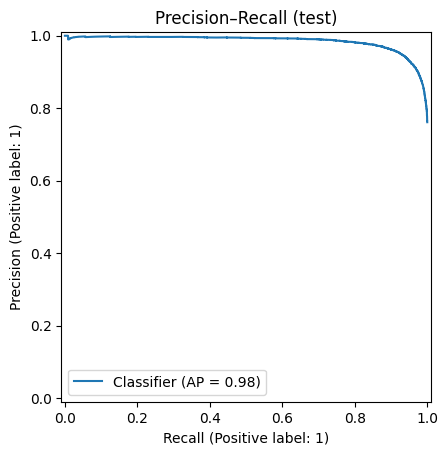

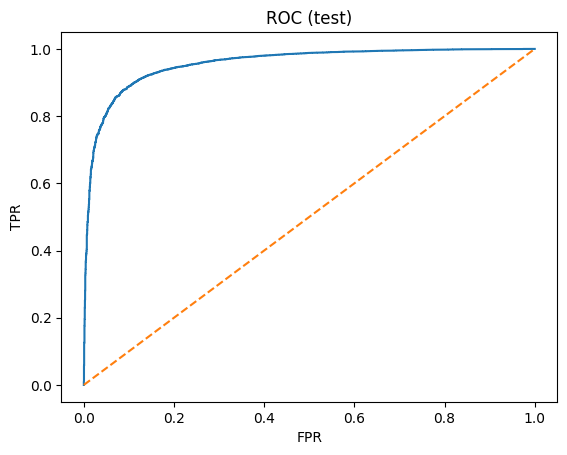

In [ ]:
# === METRICS-ONLY (pas de ré-entraînement, pas de GridSearch) ===
import numpy as np, pandas as pd
from sklearn.metrics import (precision_recall_curve, accuracy_score, balanced_accuracy_score,
                             precision_score, recall_score, f1_score, roc_auc_score,
                             average_precision_score, confusion_matrix, classification_report)
import matplotlib.pyplot as plt

def predict_proba_in_batches(clf, X, batch=20000):
    """Evite la surconsommation mémoire pour de gros X."""
    n = X.shape[0]
    out = np.empty(n, dtype=np.float32)
    for i in range(0, n, batch):
        j = min(i+batch, n)
        out[i:j] = clf.predict_proba(X[i:j])[:, 1]
    return out

# 1) Probas validation & seuil optimal F1 (t*) — on peut utiliser 'gs.best_estimator_' s’il existe, sinon 'best'
est_for_val = gs.best_estimator_ if 'gs' in globals() else best
proba_va = predict_proba_in_batches(est_for_val, X_va_)
prec, rec, thr = precision_recall_curve(y_va, proba_va)
f1_curve = (2*prec*rec)/(prec+rec+1e-9)
idx = int(np.nanargmax(f1_curve))
t_star = float(thr[idx]) if idx < len(thr) else 0.5
print(f"Seuil optimal (validation) t* = {t_star:.3f}")

# 2) Probas test avec le modèle final 'best'
proba_te = predict_proba_in_batches(best, X_te_)

def metrics_at_threshold(y_true, proba, thr, label):
    y_pred = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        "setting": label, "threshold": thr,
        "AP": average_precision_score(y_true, proba),
        "ROC_AUC": roc_auc_score(y_true, proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "BalancedAcc": balanced_accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "Specificity": tn / (tn + fp + 1e-9),
        "NPV": tn / (tn + fn + 1e-9),
        "TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn),
    }

# 3) Tableau de métriques (test) @0.5 et @t*
rows = [
    metrics_at_threshold(y_te, proba_te, 0.5, "Test @0.5"),
    metrics_at_threshold(y_te, proba_te, t_star, "Test @t*"),
]
df_metrics = pd.DataFrame(rows)
display(df_metrics)

# 4) Matrices & rapports (test)
def print_cm(y_true, proba, thr, title):
    y_pred = (proba >= thr).astype(int)
    print(f"\n{title} (thr={thr:.2f})")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=3))

print_cm(y_te, proba_te, 0.5, "Confusion matrix — Test @0.5")
print_cm(y_te, proba_te, t_star, "Confusion matrix — Test @t*")

# 5) Courbes PR & ROC (test)
from sklearn.metrics import roc_curve, PrecisionRecallDisplay
disp = PrecisionRecallDisplay.from_predictions(y_te, proba_te)
disp.ax_.set_title("Precision–Recall (test)")
plt.show()

fpr, tpr, _ = roc_curve(y_te, proba_te)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
plt.title("ROC (test)"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

Ce qui change en passant de 0.5 → 0.27

Comptes (test, N=12 000) :

@0.5 : TN=2537, FP=326, FN=955, TP=8182

@t*=0.27 : TN=2170, FP=693, FN=429, TP=8708

Différences : TP +526, FN –526 (on rate beaucoup moins de positifs) ; FP +367, TN –367 (on se trompe plus souvent sur les négatifs).

Métriques clés :

Classe 1 (positif) :

Rappel ↑ 0.895 → 0.953 (on attrape bien plus de positifs)

Précision ↓ 0.962 → 0.926 (un peu plus de faux positifs)

F1 ↑ 0.927 → 0.939

Classe 0 (négatif) :

Rappel ↓ 0.886 → 0.758 (on loupe plus de négatifs)

Précision ↑ 0.727 → 0.835 (ceux prédits négatifs sont plus “propres”)

F1 ≈ 0.798 → 0.795 (quasi inchangé)

Global :

Accuracy ↑ 0.893 → 0.906

F1 macro ↑ 0.863 → 0.867 (léger mieux)

F1 pondéré ↑ 0.897 → 0.905

👉 En bref : t* = 0.27 augmente la récupération des avis positifs (moins de FN), au prix d’un peu plus de faux positifs. L’accuracy et le F1 global montent légèrement.

In [ ]:
# On réutilise le meilleur modèle cv pour déterminer un seuil sur la validation seule
proba_va = gs.best_estimator_.predict_proba(X_va_)[:,1]

# 1) t* qui maximise F1
prec, rec, thr = precision_recall_curve(y_va, proba_va)
f1 = (2*prec*rec)/(prec+rec+1e-9)
idx = int(np.nanargmax(f1))
t_star = float(thr[idx]) if idx < len(thr) else 0.5

# 2) (option) seuil métier: ex. précision >= 0.9
t_prec90 = None
for p, r, t in zip(prec, rec, np.r_[thr, 1.0]):
    if p >= 0.90:
        t_prec90 = float(t); break

print(f"Seuil F1* = {t_star:.2f}", "| Seuil précision>=0.90:", t_prec90)

Seuil F1* = 0.30 | Seuil précision>=0.90: 0.18620296551666296


## 🚀 6) Sérialiser le modèle final + métadonnées (incluant le seuil)

In [ ]:
ap      = df_metrics.loc[df_metrics['setting']=="Test @0.5", "AP"].values[0]
roc     = df_metrics.loc[df_metrics['setting']=="Test @0.5", "ROC_AUC"].values[0]
f1_05   = df_metrics.loc[df_metrics['setting']=="Test @0.5", "F1"].values[0]
f1_t    = df_metrics.loc[df_metrics['setting']=="Test @t*",  "F1"].values[0]

In [ ]:
stamp = time.strftime("%Y%m%d_%H%M%S")
art = {
    "model": best,
    "selector_chi2": sel,      # peut être None si tu n'as pas appliqué chi²
    "selector_l1": sfm,        # idem
    "svd": svd_pipe,           # idem
    "threshold": t_star,
    "metrics_test": {"AP": float(ap), "ROC_AUC": float(roc), "F1@0.5": float(f1_05), "F1@t*": float(f1_t)},
    "params": {"C": float(gs.best_params_["C"]), "penalty": "l2", "solver": "lbfgs", "class_weight": "balanced"},
    "created": stamp
}
out_path = OUT_DIR / f"clf_logreg_chi2_final_{stamp}.joblib"
dump(art, out_path, compress=3)

meta = {
    "artifact": out_path.name,
    "X_shape": list(X_all.shape),
    "train/val/test": {"train": int(X_tr_.shape[0]), "val": int(X_va_.shape[0]), "test": int(X_te_.shape[0])},
    "threshold": float(t_star),
    "notes": "TF-IDF -> chi2(k) -> LogReg(lbfgs)."
}
(Path(OUT_DIR)/f"clf_logreg_chi2_final_{stamp}.json").write_text(json.dumps(meta, indent=2), encoding="utf-8")
print("Écrit ->", out_path.name)


Écrit -> clf_logreg_chi2_final_20250922_030316.joblib


In [13]:
# === Cell 1: Params ===
from pathlib import Path
import time, json, numpy as np, pandas as pd

RNG = 42
N   = 200_000                   # <- on entraine sur 200k lignes
DATA_PARQUET = Path("data/interim/amazon_electronics_normalized.parquet")  # ton fichier 200k
MODELS_DIR   = Path("models"); MODELS_DIR.mkdir(parents=True, exist_ok=True)

TEXT_COL = "review_body"        # adapte si besoin
# Essaie ces colonnes comme cible binaire (1 = positif)
CAND_Y = ["label_binary","is_positive","target","y","sentiment_binary"]

print("Parquet attendu:", DATA_PARQUET.resolve())

Parquet attendu: C:\Users\antoi\OneDrive\Documents\Ynov\Projet fil rouge\Bloc 5\amazon-reviews-insights\notebooks\data\interim\amazon_electronics_normalized.parquet


In [14]:
# === Cell 2: Charger 200k & cible binaire ===
assert DATA_PARQUET.exists(), "Parquet introuvable. Vérifie DATA_PARQUET."
df = pd.read_parquet(DATA_PARQUET)
print("Shape parquet:", df.shape)

# on garde les N premières (ou moins si dataset plus petit)
dfN = df.iloc[:N].copy()
assert TEXT_COL in dfN.columns, f"Colonne texte '{TEXT_COL}' absente."

# cible binaire: on prend la première colonne qui existe parmi CAND_Y
y = None
for c in CAND_Y:
    if c in dfN.columns:
        y = dfN[c].astype(int).to_numpy()
        print("Cible binaire trouvée dans la colonne:", c)
        break

# Si pas trouvé, REMPLACE par ta règle métier (ex: étoiles >=4)
if y is None:
    # EXEMPLE: si tu as 'star_rating' dans le parquet
    if "star_rating" in dfN.columns:
        y = (dfN["star_rating"].astype(int) >= 4).astype(int).to_numpy()
        print("Cible construite à partir de star_rating >= 4")
    else:
        raise AssertionError(
            "Aucune cible binaire trouvée. Ajoute une colonne (ex: label_binary) "
            "ou adapte la règle avec star_rating."
        )

texts = dfN[TEXT_COL].astype(str).tolist()
print(f"n_texts: {len(texts)} | pos_ratio: {y.mean():.3f}")

Shape parquet: (1314720, 11)
Cible construite à partir de star_rating >= 4
n_texts: 200000 | pos_ratio: 0.793


In [15]:
# === Cell 3: TF-IDF(200k) ===
from sklearn.feature_extraction.text import TfidfVectorizer
import time, joblib

vec_word = TfidfVectorizer(
    lowercase=True, strip_accents="unicode",
    token_pattern=r"(?u)\b\w\w+\b",
    ngram_range=(1,2),
    min_df=2, max_df=0.95,
    max_features=200_000,
    analyzer="word"
)
vec_char = TfidfVectorizer(
    lowercase=True, strip_accents="unicode",
    ngram_range=(3,5),
    min_df=2, max_df=0.95,
    max_features=100_000,
    analyzer="char"
)

t0 = time.time()
Xw = vec_word.fit_transform(texts)
Xc = vec_char.fit_transform(texts)
print(f"TF-IDF fit en {time.time()-t0:.1f}s | word={Xw.shape} char={Xc.shape}")

# on ne stocke QUE les vectorizers (léger)
stamp = time.strftime("%Y%m%d_%H%M%S")
tfidf_art = {
    "vectorizer_word": vec_word,
    "vectorizer_char": vec_char,
    "created": stamp,
    "params": {
        "word": {"ngram": (1,2), "min_df":2, "max_df":0.95, "max_features": 200_000},
        "char": {"ngram": (3,5), "min_df":2, "max_df":0.95, "max_features": 100_000},
    }
}
tfidf_path = MODELS_DIR / f"features_tfidf_runtime_full_{stamp}.joblib"
joblib.dump(tfidf_art, tfidf_path, compress=3)
print("✔ TF-IDF sauvegardé ->", tfidf_path.name)

TF-IDF fit en 81.1s | word=(200000, 200000) char=(200000, 100000)
✔ TF-IDF sauvegardé -> features_tfidf_runtime_full_20250922_043241.joblib


In [16]:
# === Cell 4: split + vectorize + chi2 ===
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.feature_selection import SelectKBest, chi2

# splits
X_tr_txt, X_tmp_txt, y_tr, y_tmp = train_test_split(
    texts, y, test_size=0.20, stratify=y, random_state=RNG
)
X_va_txt, X_te_txt, y_va, y_te = train_test_split(
    X_tmp_txt, y_tmp, test_size=0.50, stratify=y_tmp, random_state=RNG
)
print(f"split sizes -> train:{len(X_tr_txt)} val:{len(X_va_txt)} test:{len(X_te_txt)}")

# vectorize avec les vectorizers tout juste fités
X_tr_w = vec_word.transform(X_tr_txt); X_tr_c = vec_char.transform(X_tr_txt)
X_va_w = vec_word.transform(X_va_txt); X_va_c = vec_char.transform(X_va_txt)
X_te_w = vec_word.transform(X_te_txt); X_te_c = vec_char.transform(X_te_txt)

X_tr = sparse.hstack([X_tr_w, X_tr_c]).tocsr()
X_va = sparse.hstack([X_va_w, X_va_c]).tocsr()
X_te = sparse.hstack([X_te_w, X_te_c]).tocsr()
print("shapes:", X_tr.shape, X_va.shape, X_te.shape)

# chi²: on FITTE sur TRAIN (important pour que n_in corresponde)
K = 50_000  # k out
sel = SelectKBest(score_func=chi2, k=K)
X_tr_ = sel.fit_transform(X_tr, y_tr)
X_va_ = sel.transform(X_va)
X_te_ = sel.transform(X_te)
print("after chi²:", X_tr_.shape)

split sizes -> train:160000 val:20000 test:20000
shapes: (160000, 300000) (20000, 300000) (20000, 300000)
after chi²: (160000, 50000)


In [17]:
# === Cell 5: train LR + métriques + save bundle ===
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (precision_recall_curve, confusion_matrix,
                             average_precision_score, roc_auc_score, f1_score,
                             accuracy_score, balanced_accuracy_score, classification_report)
import numpy as np, pandas as pd, joblib, time

# gridsearch
param_grid = {"C": [0.25, 0.5, 1.0, 2.0]}
base = LogisticRegression(solver="lbfgs", penalty="l2", class_weight="balanced",
                          max_iter=5000, tol=1e-3)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RNG)
gs = GridSearchCV(base, param_grid=param_grid, scoring="average_precision",
                  cv=cv, n_jobs=1, pre_dispatch=1, refit=True, verbose=1)

t0 = time.time()
gs.fit(X_tr_, y_tr)
print("Best:", gs.best_params_, "AP(CV)=", gs.best_score_)

# refit sur train+val
X_trva_ = sparse.vstack([X_tr_, X_va_])
y_trva  = np.hstack([y_tr, y_va])
best = LogisticRegression(solver="lbfgs", penalty="l2", class_weight="balanced",
                          C=gs.best_params_["C"], max_iter=5000, tol=1e-3)
best.fit(X_trva_, y_trva)

# proba val pour t*
proba_va = gs.best_estimator_.predict_proba(X_va_)[:,1]
prec, rec, thr = precision_recall_curve(y_va, proba_va)
f1_curve = (2*prec*rec)/(prec+rec+1e-9)
i = int(np.nanargmax(f1_curve))
t_star = float(thr[i]) if i < len(thr) else 0.5
print(f"t* (val) = {t_star:.2f}")

# proba test + métriques
proba_te = best.predict_proba(X_te_)[:,1]

def metrics_at(y_true, p, thr, label):
    y_pred = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        "setting": label, "thr": thr,
        "AP": average_precision_score(y_true, p),
        "ROC_AUC": roc_auc_score(y_true, p),
        "Accuracy": accuracy_score(y_true, y_pred),
        "BalancedAcc": balanced_accuracy_score(y_true, y_pred),
        "Precision": (tp/(tp+fp)) if (tp+fp)>0 else 0.0,
        "Recall": (tp/(tp+fn)) if (tp+fn)>0 else 0.0,
        "F1": f1_score(y_true, y_pred)
    }

dfm = pd.DataFrame([
    metrics_at(y_te, proba_te, 0.5, "Test@0.5"),
    metrics_at(y_te, proba_te, t_star, "Test@t*")
])
display(dfm)

def print_cm(y_true, p, thr, title):
    y_pred = (p >= thr).astype(int)
    print(f"\n{title} (thr={thr:.2f})")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=3))

print_cm(y_te, proba_te, 0.5,  "Confusion matrix — Test @0.5")
print_cm(y_te, proba_te, t_star, f"Confusion matrix — Test @t*")

# save bundle complet
stamp = time.strftime("%Y%m%d_%H%M%S")
bundle = {
    "model": best,
    "selector_chi2": sel,
    "vectorizer_word": vec_word,
    "vectorizer_char": vec_char,
    "threshold": t_star,
    "meta": {
        "n_rows": int(len(texts)),
        "split": {"train": int(len(y_tr)), "val": int(len(y_va)), "test": int(len(y_te))},
        "tfidf_runtime": tfidf_path.name,
        "created": stamp
    }
}
out = MODELS_DIR / f"sentiment_bundle_runtime_{stamp}.joblib"
joblib.dump(bundle, out, compress=3)
print("✔ Bundle sentiment sauvegardé ->", out.name)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best: {'C': 0.5} AP(CV)= 0.985878656376807
t* (val) = 0.25


,setting,thr,AP,ROC_AUC,Accuracy,BalancedAcc,Precision,Recall,F1
0,Test@0.5,0.50000,0.982145,0.938004,0.8547,0.865313,0.965384,0.847220,0.902450
1,Test@t*,0.25285,0.982145,0.938004,0.8929,0.811493,0.917651,0.950271,0.933676



Confusion matrix — Test @0.5 (thr=0.50)
[[ 3652   482]
 [ 2424 13442]]
              precision    recall  f1-score   support

           0      0.601     0.883     0.715      4134
           1      0.965     0.847     0.902     15866

    accuracy                          0.855     20000
   macro avg      0.783     0.865     0.809     20000
weighted avg      0.890     0.855     0.864     20000


Confusion matrix — Test @t* (thr=0.25)
[[ 2781  1353]
 [  789 15077]]
              precision    recall  f1-score   support

           0      0.779     0.673     0.722      4134
           1      0.918     0.950     0.934     15866

    accuracy                          0.893     20000
   macro avg      0.848     0.811     0.828     20000
weighted avg      0.889     0.893     0.890     20000

✔ Bundle sentiment sauvegardé -> sentiment_bundle_runtime_20250922_043451.joblib


In [11]:
DATA_DIR = Path("data/processed")
MODELS_DIR = Path("models")

# Charger les derniers X/y
X_paths = sorted(DATA_DIR.glob("X_tfidf*.npz"))
y_paths = sorted(DATA_DIR.glob("y_*binary*.joblib"))
assert X_paths and y_paths, "Génère X/y en C5.2.1."
X_all = sparse.load_npz(X_paths[-1]).tocsr().astype(np.float32)
y_all = load(y_paths[-1]).astype(np.int8)
print("X:", X_all.shape, "| y:", y_all.shape, "| pos_ratio:", y_all.mean())

# Charger le dernier bundle sentiment si dispo
bundle_paths = sorted(MODELS_DIR.glob("clf_logreg_chi2_final_*.joblib"))
bundle = load(bundle_paths[-1]) if bundle_paths else None
print("bundle sentiment:", bundle_paths[-1].name if bundle else "None")

if bundle:
    print("clés bundle:", list(bundle.keys()))

X: (120000, 180007) | y: (120000,) | pos_ratio: 0.7614583333333333
bundle sentiment: clf_logreg_chi2_final_20250919_114948.joblib
clés bundle: ['model', 'selector_chi2', 'selector_l1', 'svd', 'threshold', 'metrics_test', 'params', 'created']


In [18]:
# === Cell 1: Params & paths ===
from pathlib import Path
import time, json, numpy as np, pandas as pd

RNG = 42
N   = 200_000  # <- on entraîne sur 200k lignes

DATA_PARQUET = Path("data/interim/amazon_electronics_normalized.parquet")  # ton fichier normalisé
MODELS_DIR   = Path("models"); MODELS_DIR.mkdir(parents=True, exist_ok=True)

TEXT_COL = "review_body"  # adapte si besoin

# Cible binaire (1 = positif) : on teste ces noms de colonnes, sinon fallback sur star_rating>=4
CAND_Y = ["label_binary","is_positive","target","y","sentiment_binary"]

print("Parquet attendu:", DATA_PARQUET.resolve())

Parquet attendu: C:\Users\antoi\OneDrive\Documents\Ynov\Projet fil rouge\Bloc 5\amazon-reviews-insights\notebooks\data\interim\amazon_electronics_normalized.parquet


In [19]:
# === Cell 2: Charger 200k & cible binaire ===
assert DATA_PARQUET.exists(), "Parquet introuvable. Vérifie DATA_PARQUET."
df = pd.read_parquet(DATA_PARQUET)
print("Shape parquet:", df.shape)

# on garde les N premières (ou moins si dataset plus petit)
dfN = df.iloc[:N].copy()
assert TEXT_COL in dfN.columns, f"Colonne texte '{TEXT_COL}' absente."

# cible binaire: on prend la première colonne qui existe parmi CAND_Y
y = None
for c in CAND_Y:
    if c in dfN.columns:
        y = dfN[c].astype(int).to_numpy()
        print("Cible binaire trouvée dans la colonne:", c)
        break

# Si pas trouvé, fallback (ex: 1 si star_rating >= 4)
if y is None:
    if "star_rating" in dfN.columns:
        y = (dfN["star_rating"].astype(int) >= 4).astype(int).to_numpy()
        print("Cible construite à partir de star_rating >= 4")
    else:
        raise AssertionError(
            "Aucune cible binaire trouvée. Ajoute une colonne (ex: label_binary) "
            "ou adapte la règle avec star_rating."
        )

texts = dfN[TEXT_COL].astype(str).tolist()
print(f"n_texts: {len(texts)} | pos_ratio: {y.mean():.3f}")

Shape parquet: (1314720, 11)
Cible construite à partir de star_rating >= 4
n_texts: 200000 | pos_ratio: 0.793


In [20]:
# === Cell 3: TF-IDF word+char (300k) — FIT 1x & SAVE ===
from joblib import dump
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np, time

# Vectorizer WORD: 1-2grams, 200k features
vec_word = TfidfVectorizer(
    lowercase=True, strip_accents="unicode",
    token_pattern=r"(?u)\b\w\w+\b",
    ngram_range=(1,2),
    min_df=2, max_df=0.90,
    analyzer="word",
    max_features=200_000,
    dtype=np.float32,
    sublinear_tf=True
)

# Vectorizer CHAR: 3-5grams, 100k features
vec_char = TfidfVectorizer(
    lowercase=True, strip_accents="unicode",
    ngram_range=(3,5),
    min_df=2,              # max_df pas nécessaire sur char-ngrams
    analyzer="char",
    max_features=100_000,
    dtype=np.float32,
    sublinear_tf=True
)

t0 = time.time()
vec_word.fit(texts)  # fit sur les 200k textes (ou moins si df < N)
vec_char.fit(texts)
print(f"Vocab sizes -> word: {len(vec_word.vocabulary_)} | char: {len(vec_char.vocabulary_)} | elapsed: {time.time()-t0:.1f}s")

stamp = time.strftime("%Y%m%d_%H%M%S")
tfidf_path = MODELS_DIR / f"features_tfidf_runtime_full_{stamp}.joblib"
dump({"vectorizer_word": vec_word, "vectorizer_char": vec_char, "created": stamp}, tfidf_path, compress=3)
print("✔ TF-IDF runtime sauvegardé ->", tfidf_path.name)

Vocab sizes -> word: 200000 | char: 100000 | elapsed: 86.7s
✔ TF-IDF runtime sauvegardé -> features_tfidf_runtime_full_20250922_045623.joblib


In [21]:
# === Cell 4: split + LOAD TF-IDF + vectorize + chi2 ===
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from scipy import sparse

# splits
X_tr_txt, X_tmp_txt, y_tr, y_tmp = train_test_split(
    texts, y, test_size=0.20, stratify=y, random_state=RNG
)
X_va_txt, X_te_txt, y_va, y_te = train_test_split(
    X_tmp_txt, y_tmp, test_size=0.50, stratify=y_tmp, random_state=RNG
)
print(f"split sizes -> train:{len(X_tr_txt)} val:{len(X_va_txt)} test:{len(X_te_txt)}")

# LOAD dernier TF-IDF sauvegardé à la cellule 3
TFIDF_FILE = sorted(MODELS_DIR.glob("features_tfidf_runtime_full_*.joblib"))[-1]
tfidf_obj = load(TFIDF_FILE)
vec_word, vec_char = tfidf_obj["vectorizer_word"], tfidf_obj["vectorizer_char"]
print("TF-IDF used:", TFIDF_FILE.name)

# vectorize
X_tr_w = vec_word.transform(X_tr_txt); X_tr_c = vec_char.transform(X_tr_txt)
X_va_w = vec_word.transform(X_va_txt); X_va_c = vec_char.transform(X_va_txt)
X_te_w = vec_word.transform(X_te_txt); X_te_c = vec_char.transform(X_te_txt)

X_tr = sparse.hstack([X_tr_w, X_tr_c], format="csr")
X_va = sparse.hstack([X_va_w, X_va_c], format="csr")
X_te = sparse.hstack([X_te_w, X_te_c], format="csr")
print("shapes (pre-chi2):", X_tr.shape, X_va.shape, X_te.shape)  # attendu ~ (.., 300000)

# chi²: FIT sur TRAIN -> réduit à K
K = 50_000
sel = SelectKBest(score_func=chi2, k=K)
X_tr_ = sel.fit_transform(X_tr, y_tr)
X_va_ = sel.transform(X_va)
X_te_ = sel.transform(X_te)
print("after chi²:", X_tr_.shape)  # attendu -> (.., 50000)

# (optionnel) sanity dims pour éviter toute régression
assert getattr(sel, "n_features_in_", None) == (200_000 + 100_000), "chi² n_features_in_ doit valoir 300000"

split sizes -> train:160000 val:20000 test:20000
TF-IDF used: features_tfidf_runtime_full_20250922_045623.joblib
shapes (pre-chi2): (160000, 300000) (20000, 300000) (20000, 300000)
after chi²: (160000, 50000)


In [22]:
# === Cell 5: train LR + métriques + save bundle ===
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (precision_recall_curve, confusion_matrix,
                             average_precision_score, roc_auc_score, f1_score,
                             accuracy_score, balanced_accuracy_score, classification_report)
import numpy as np, pandas as pd, joblib, time
from scipy import sparse

# GridSearch sur C
param_grid = {"C": [0.25, 0.5, 1.0, 2.0]}
base = LogisticRegression(
    solver="lbfgs", penalty="l2", class_weight="balanced",
    max_iter=5000, tol=1e-3
)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RNG)
gs = GridSearchCV(base, param_grid=param_grid, scoring="average_precision",
                  cv=cv, n_jobs=1, pre_dispatch=1, refit=True, verbose=1)

t0 = time.time()
gs.fit(X_tr_, y_tr)
print("Best:", gs.best_params_, "AP(CV)=", gs.best_score_, "| fit:", f"{time.time()-t0:.1f}s")

# Refit final sur train+val
X_trva_ = sparse.vstack([X_tr_, X_va_])
y_trva  = np.hstack([y_tr, y_va])
best = LogisticRegression(
    solver="lbfgs", penalty="l2", class_weight="balanced",
    C=gs.best_params_["C"], max_iter=5000, tol=1e-3
).fit(X_trva_, y_trva)

# Seuil t* sur la validation (max F1)
proba_va = gs.best_estimator_.predict_proba(X_va_)[:,1]
prec, rec, thr = precision_recall_curve(y_va, proba_va)
f1_curve = (2*prec*rec)/(prec+rec+1e-9)
i = int(np.nanargmax(f1_curve))
t_star = float(thr[i]) if i < len(thr) else 0.5
print(f"t* (val) = {t_star:.3f}")

# Évaluation sur test
proba_te = best.predict_proba(X_te_)[:,1]

def metrics_at(y_true, p, thr, label):
    y_pred = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        "setting": label, "thr": thr,
        "AP": average_precision_score(y_true, p),
        "ROC_AUC": roc_auc_score(y_true, p),
        "Accuracy": accuracy_score(y_true, y_pred),
        "BalancedAcc": balanced_accuracy_score(y_true, y_pred),
        "Precision": (tp/(tp+fp)) if (tp+fp)>0 else 0.0,
        "Recall": (tp/(tp+fn)) if (tp+fn)>0 else 0.0,
        "F1": f1_score(y_true, y_pred)
    }

dfm = pd.DataFrame([
    metrics_at(y_te, proba_te, 0.5, "Test@0.5"),
    metrics_at(y_te, proba_te, t_star, "Test@t*")
])
display(dfm)

def print_cm(y_true, p, thr, title):
    y_pred = (p >= thr).astype(int)
    print(f"\n{title} (thr={thr:.2f})")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=3))

print_cm(y_te, proba_te, 0.5,  "Confusion matrix — Test @0.5")
print_cm(y_te, proba_te, t_star, f"Confusion matrix — Test @t*")

# Sauvegarde du bundle complet (avec nom stable pour Streamlit)
stamp = time.strftime("%Y%m%d_%H%M%S")
bundle = {
    "model": best,
    "selector_chi2": sel,
    "vectorizer_word": vec_word,
    "vectorizer_char": vec_char,
    "threshold": float(t_star),
    "meta": {
        "n_rows": int(len(texts)),
        "split": {"train": int(len(y_tr)), "val": int(len(y_va)), "test": int(len(y_te))},
        "tfidf_runtime": Path(TFIDF_FILE).name,
        "created": stamp
    }
}
out = MODELS_DIR / f"sentiment_bundle_runtime_{stamp}.joblib"
joblib.dump(bundle, out, compress=3)
joblib.dump(bundle, MODELS_DIR / "sentiment_bundle_runtime.joblib", compress=3)  # nom fixe pour l'app
print("✔ Bundle sentiment sauvegardé ->", out.name)
print("✔ Copie pour l'app -> sentiment_bundle_runtime.joblib")


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best: {'C': 1.0} AP(CV)= 0.9865423632195015 | fit: 29.1s
t* (val) = 0.220


,setting,thr,AP,ROC_AUC,Accuracy,BalancedAcc,Precision,Recall,F1
0,Test@0.5,0.500000,0.984205,0.944472,0.86715,0.875933,0.968039,0.860961,0.911365
1,Test@t*,0.220069,0.984205,0.944472,0.89715,0.811757,0.916712,0.957330,0.936581



Confusion matrix — Test @0.5 (thr=0.50)
[[ 3683   451]
 [ 2206 13660]]
              precision    recall  f1-score   support

           0      0.625     0.891     0.735      4134
           1      0.968     0.861     0.911     15866

    accuracy                          0.867     20000
   macro avg      0.797     0.876     0.823     20000
weighted avg      0.897     0.867     0.875     20000


Confusion matrix — Test @t* (thr=0.22)
[[ 2754  1380]
 [  677 15189]]
              precision    recall  f1-score   support

           0      0.803     0.666     0.728      4134
           1      0.917     0.957     0.937     15866

    accuracy                          0.897     20000
   macro avg      0.860     0.812     0.832     20000
weighted avg      0.893     0.897     0.893     20000

✔ Bundle sentiment sauvegardé -> sentiment_bundle_runtime_20250922_045812.joblib
✔ Copie pour l'app -> sentiment_bundle_runtime.joblib


In [23]:
# === Cell 6 (option): sanity dims ===
from joblib import load
b = load(MODELS_DIR / "sentiment_bundle_runtime.joblib")
v_w = b["vectorizer_word"]; v_c = b["vectorizer_char"]; sel2 = b["selector_chi2"]; lr2 = b["model"]

print("word vocab:", len(v_w.vocabulary_), "char vocab:", len(v_c.vocabulary_))
print("chi2 n_in:", getattr(sel2, "n_features_in_", None), "n_out:", sel2.get_support().sum())
print("LR coef dims:", lr2.coef_.shape)

# test rapide sur 3 textes
Xw = v_w.transform(texts[:3]); Xc = v_c.transform(texts[:3])
X  = sparse.hstack([Xw, Xc], format="csr")
X_ = sel2.transform(X)
print("X test shapes:", X.shape, "->", X_.shape)
print("proba:", lr2.predict_proba(X_)[:,1])

word vocab: 200000 char vocab: 100000
chi2 n_in: 300000 n_out: 50000
LR coef dims: (1, 50000)
X test shapes: (3, 300000) -> (3, 50000)
proba: [0.7380225  0.80310091 0.01028482]


## B) ÉMOTIONS (multi-label) — teacher → pseudo-labels → student SBERT

- Idée : on utilise un modèle pré-entraîné émotions (teacher) pour pseudo-labelliser un échantillon de tes avis.
- Puis on entraîne un student rapide : SBERT embeddings → One-vs-Rest LogReg (multi-label).

> Modèle teacher conseillé : joeddav/distilbert-base-uncased-go-emotions-student (léger, 28 émotions GoEmotions).

In [44]:
# B1) Charger le texte brut (le parquet/CSV normalisé C5.1.1)
TEXT_PARQUET = DATA_DIR / "C:/Users/antoi/OneDrive/Documents/Ynov/Projet fil rouge/Bloc 5/amazon-reviews-insights/notebooks/data/interim/amazon_electronics_normalized.parquet"  # adapte si besoin
assert TEXT_PARQUET.exists(), f"{TEXT_PARQUET} introuvable (exporte le parquet en C5.1.1)."
df = pd.read_parquet(TEXT_PARQUET)
assert "review_body" in df.columns, "Colonne review_body absente."
texts = df["review_body"].astype(str).tolist()
len(texts)

1314720

In [13]:
# B2) Pseudo-labels avec un teacher émotions (cache en Parquet)
from transformers import pipeline

EMO_PSEUDO = PSEUDO_DIR / "emotions_goemotions.parquet"
LABELS_EMO = None

if EMO_PSEUDO.exists():
    emo_df = pd.read_parquet(EMO_PSEUDO)
    LABELS_EMO = [c for c in emo_df.columns if c.startswith("emo_")]
    print("Pseudo-labels émotions chargés:", EMO_PSEUDO.name)
else:
    emo_pipe = pipeline(
        "text-classification",
        model="joeddav/distilbert-base-uncased-go-emotions-student",
        return_all_scores=True, device=DEVICE
    )
    # ⚠️ pour le temps : prends un sous-échantillon (ex. 20k) ajustable
    N_EMO = min(20_000, len(texts))
    subset = texts[:N_EMO]
    rows = []
    for scores in emo_pipe(subset, truncation=True, batch_size=32):
        d = {f"emo_{s['label']}": s["score"] for s in scores}
        rows.append(d)
    emo_df = pd.DataFrame(rows).fillna(0.0)
    LABELS_EMO = emo_df.columns.tolist()
    emo_df.to_parquet(EMO_PSEUDO)
    print("Écrit pseudo-labels →", EMO_PSEUDO.name)

emo_df.head(3)

c:\Users\antoi\OneDrive\Documents\Ynov\Projet fil rouge\Bloc 5\amazon-reviews-insights\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pseudo-labels émotions chargés: emotions_goemotions.parquet


,emo_admiration,emo_amusement,emo_anger,emo_annoyance,emo_approval,emo_caring,emo_confusion,emo_curiosity,emo_desire,emo_disappointment,...,emo_love,emo_nervousness,emo_optimism,emo_pride,emo_realization,emo_relief,emo_remorse,emo_sadness,emo_surprise,emo_neutral
0,0.024528,0.029084,0.008323,0.013083,0.172813,0.097214,0.010340,0.037348,0.024304,0.003253,...,0.010833,0.018691,0.059951,0.046197,0.128518,0.078238,0.012864,0.007100,0.013990,0.107642
1,0.011498,0.018305,0.013782,0.055266,0.011068,0.030725,0.194204,0.267595,0.013572,0.036567,...,0.005770,0.010786,0.012822,0.015537,0.040306,0.011791,0.025946,0.021633,0.023347,0.020215
2,0.011156,0.011995,0.056976,0.176052,0.044198,0.040557,0.056490,0.029104,0.033992,0.067785,...,0.005387,0.027594,0.014821,0.021097,0.047439,0.015241,0.039175,0.017035,0.029049,0.012227


In [14]:
# B3) Multi-hot (seuil), split, SBERT embeddings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sentence_transformers import SentenceTransformer

# Seuil d'activation par émotion (simple): 0.30
TH_EMO = 0.30
Y = (emo_df.values >= TH_EMO).astype(int)

# textes alignés au pseudo labelling (si sous-échantillonnage)
N = len(emo_df); texts_emo = texts[:N]

X_tr_txt, X_te_txt, Y_tr, Y_te = train_test_split(texts_emo, Y, test_size=0.2, random_state=RNG)

sbert = SentenceTransformer("all-MiniLM-L6-v2", device="cuda" if USE_GPU else "cpu")
X_tr_emb = sbert.encode(X_tr_txt, batch_size=256, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
X_te_emb = sbert.encode(X_te_txt, batch_size=256, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
X_tr_emb.shape, Y_tr.shape

c:\Users\antoi\OneDrive\Documents\Ynov\Projet fil rouge\Bloc 5\amazon-reviews-insights\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches:   0%|          | 0/63 [00:00<?, ?it/s]c:\Users\antoi\OneDrive\Documents\Ynov\Projet fil rouge\Bloc 5\amazon-reviews-insights\.venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Batches: 100%|██████████| 16/16 [00:01<00:00, 14.96it/s]


((16000, 384), (16000, 28))

In [15]:
# === Filtrer les étiquettes trop rares ===
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import average_precision_score, f1_score

labels = np.array(LABELS_EMO)  # déjà défini plus haut
cnt_tr = Y_tr.sum(axis=0).astype(int)
cnt_te = Y_te.sum(axis=0).astype(int)

MIN_TR, MIN_TE = 30, 5  # à ajuster selon la taille de ton sous-échantillon
keep = (cnt_tr >= MIN_TR) & (cnt_te >= MIN_TE)
print(f"On garde {keep.sum()} / {len(keep)} labels :", labels[keep].tolist())

Ytr_k = Y_tr[:, keep]
Yte_k = Y_te[:, keep]

# (conseillé) standardiser les embeddings SBERT
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
Xtr_s = scaler.fit_transform(X_tr_emb)
Xte_s = scaler.transform(X_te_emb)

emo_clf = OneVsRestClassifier(
    LogisticRegression(max_iter=3000, class_weight="balanced", solver="lbfgs", C=1.0)
)
emo_clf.fit(Xtr_s, Ytr_k)

proba = emo_clf.predict_proba(Xte_s)
pred  = (proba >= 0.5).astype(int)

aps = [average_precision_score(Yte_k[:,j], proba[:,j]) for j in range(Yte_k.shape[1]) if Yte_k[:,j].sum()>0]
ap_macro = float(np.mean(aps)) if aps else 0.0
f1_micro = f1_score(Yte_k, pred, average="micro")
print(f"ÉMOTIONS (filtrées={Ytr_k.shape[1]}) — AP_macro={ap_macro:.3f} | F1_micro={f1_micro:.3f}")

On garde 10 / 28 labels : ['emo_amusement', 'emo_annoyance', 'emo_approval', 'emo_confusion', 'emo_desire', 'emo_disappointment', 'emo_excitement', 'emo_gratitude', 'emo_relief', 'emo_surprise']
ÉMOTIONS (filtrées=10) — AP_macro=0.349 | F1_micro=0.265


In [16]:
# On repart de tes objets déjà créés : X_tr_emb, X_te_emb, Ytr_k, Yte_k
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

RNG = 42
Xtr, Xva, Ytr, Yva = train_test_split(X_tr_emb, Ytr_k, test_size=0.2, random_state=RNG)

scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)   # fit sur TRAIN seulement
Xva_s = scaler.transform(Xva)
Xte_s = scaler.transform(X_te_emb)  # transform test avec le même scaler

In [17]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve

Cs = [0.25, 0.5, 1.0, 2.0]
best = (None, -1, None)  # (clf, ap_val, proba_val)

for C in Cs:
    clf = OneVsRestClassifier(
        LogisticRegression(max_iter=3000, class_weight="balanced", solver="lbfgs", C=C)
    )
    clf.fit(Xtr_s, Ytr)
    proba_va = clf.predict_proba(Xva_s)
    aps = [average_precision_score(Yva[:, j], proba_va[:, j])
           for j in range(Yva.shape[1]) if Yva[:, j].sum() > 0]
    ap_val = float(np.mean(aps)) if aps else 0.0
    print(f"C={C} | AP_macro(val)={ap_val:.3f}")
    if ap_val > best[1]:
        best = (clf, ap_val, proba_va)

emo_clf, ap_val, proba_va = best
print("Meilleur C:", emo_clf.estimator.C, "| AP_macro(val):", ap_val)

# Seuil optimal par étiquette (max F1 sur la val)
thr = np.full(Yva.shape[1], 0.5, dtype=float)
for j in range(Yva.shape[1]):
    if Yva[:, j].sum() == 0:
        continue
    p, r, t = precision_recall_curve(Yva[:, j], proba_va[:, j])
    f1 = (2*p*r)/(p+r+1e-9)
    i = int(np.nanargmax(f1))
    thr[j] = float(t[i]) if i < len(t) else 0.5
thr[:5]

C=0.25 | AP_macro(val)=0.299
C=0.5 | AP_macro(val)=0.282
C=1.0 | AP_macro(val)=0.272
C=2.0 | AP_macro(val)=0.261
Meilleur C: 0.25 | AP_macro(val): 0.29909514751249805


array([0.92889581, 0.57873407, 0.85098745, 0.00153819, 0.92437752])

In [18]:
# Cell A - diagnostics: support labels & proba stats

# Ytr, Yva, Yte are assumed binary indicator matrices (n_samples, n_labels)
# proba_va is the predicted probabilities you already computed for the best model on val

# 1) support
support = Ytr.sum(axis=0).astype(int)
support_va = Yva.sum(axis=0).astype(int)
support_df = pd.DataFrame({
    "label_idx": np.arange(len(support)),
    "support_train": support,
    "support_val": support_va,
    "thr_val": thr
})
display(support_df.head(20))

# 2) proba distribution summary per label
proba_stats = []
for j in range(proba_va.shape[1]):
    arr = proba_va[:, j]
    proba_stats.append({
        "label": j,
        "mean": float(np.nanmean(arr)),
        "median": float(np.nanmedian(arr)),
        "std": float(np.nanstd(arr)),
        "p90": float(np.nanpercentile(arr,90)),
        "max": float(np.nanmax(arr)),
        "min": float(np.nanmin(arr))
    })
proba_stats_df = pd.DataFrame(proba_stats).sort_values("mean", ascending=False)
display(proba_stats_df.head(20))

,label_idx,support_train,support_val,thr_val
0,0,33,14,0.928896
1,1,56,10,0.578734
2,2,38,6,0.850987
3,3,49,7,0.001538
4,4,31,6,0.924378
5,5,208,53,0.989405
6,6,22,8,0.543857
7,7,60,10,0.991375
8,8,29,10,0.894084
9,9,74,21,0.956976


,label,mean,median,std,p90,max,min
5,5,0.066722,1.680241e-05,0.210534,0.125751,1.000000,7.977431e-17
9,9,0.025201,3.013404e-07,0.124662,0.007621,0.999998,2.449365e-22
7,7,0.012177,1.051932e-06,0.081696,0.003378,0.999929,1.170021e-19
1,1,0.010301,7.576484e-08,0.080434,0.000504,0.999934,1.005206e-19
3,3,0.009153,1.502633e-07,0.076637,0.000461,0.999422,1.819259e-16
8,8,0.006864,1.159819e-06,0.066170,0.000748,0.999736,2.515745e-14
0,0,0.005738,2.742051e-06,0.064872,0.000297,0.999998,3.701245e-14
2,2,0.005542,1.132588e-06,0.060432,0.000450,0.999999,4.824624e-13
6,6,0.004817,7.317568e-07,0.048072,0.000573,0.999170,1.599816e-14
4,4,0.004653,1.468289e-06,0.047442,0.000526,0.988010,3.445707e-16


# Interprétation des résultats — Support & statistiques des probabilités (Cell A)

## Rappel des colonnes
- **label_idx** : identifiant numérique de l'étiquette (emotion).  
- **support_train** : nombre d'exemples positifs pour cette étiquette dans l'ensemble d'entraînement.  
- **support_val** : nombre d'exemples positifs pour cette étiquette dans la validation.  
- **thr_val** : seuil optimisé (sur la validation) calculé pour maximiser le F1 de cette étiquette (peut être instable si peu de données).  

Le deuxième tableau donne, pour chaque étiquette, des statistiques sur les probabilités prédites (`proba_va`) :
- **mean / median / std** : mesures de tendance centrale et dispersion des probabilités.  
- **p90** : 90ᵉ centile (valeur au-dessus de laquelle se situent les 10% plus fortes probabilités).  
- **min / max** : valeurs extrêmes observées.

---

## Ce que montrent ces résultats (lecture synthétique)
1. **Déséquilibre des classes**  
   - Certaines étiquettes ont beaucoup d'exemples (ex. `support_train` ≈ 200) alors que d'autres sont rares (≈ 20–30).  
   - Les étiquettes rares ont des métriques instables et des courbes PR souvent bruyantes.

2. **Seuils très variables**  
   - Des seuils **très élevés** (≈ 0.9) signifient : le modèle n'attribue une probabilité élevée qu'à très peu d'exemples — il est très conservateur pour cette étiquette.  
   - Un seuil **très bas** (≈ 0.0015) indique que la F1 maximale s'obtient en acceptant presque toutes les prédictions non-nulles — souvent signe de distribution des probabilités très proches de zéro pour la majorité des échantillons.

3. **Distribution des probabilités**  
   - `mean` et `p90` faibles (proches de 0) pour beaucoup d'étiquettes → la majorité des prédictions sont proches de 0.  
   - `max` proche de 1 pour plusieurs labels → il existe au moins quelques prédictions très confiantes (bon signe : quelques vrais positifs très bien détectés).

---

## Interprétation opérationnelle (ce que cela signifie concrètement)
- Le modèle **repère correctement quelques exemples** avec forte confiance, mais **ne généralise pas** bien sur la majorité des cas pour certaines étiquettes (probablement à cause du peu d'exemples et/ou de features non discriminantes).  
- Les **seuils calculés sur un seul split validation peuvent être instables** (surtout pour étiquettes rares). Donc ces `thr_val` ne sont pas fiables en production sans validation supplémentaire.

---

## Recommandations immédiates (actions à court terme)
1. **Ne pas déployer des seuils quasi-zéro** : imposer un plancher (`min_threshold`, ex. 0.05) en production pour limiter les faux positifs absurdes.  
2. **Calibrer les probabilités** (CalibratedClassifierCV, `sigmoid` ou `isotonic`) pour obtenir des scores plus interprétables avant de fixer des seuils.  
3. **Estimer des seuils robustes par CV** : calculer les seuils sur plusieurs folds (p.ex. K-fold) et prendre la moyenne ou la médiane des seuils au lieu d’un unique split.  
4. **Regrouper ou ré-annoter les labels trop rares** (par ex. fusionner étiquettes proches sémantiquement) ou collecter plus d’exemples.  
5. **Tester SBERT embeddings + un classifieur (LR/MLP)** — souvent plus discriminant que TF-IDF pour émotions fines.  
6. **Utiliser des méthodes qui exploitent la corrélation entre labels** (ClassifierChain, modèles NN multi-label) si plusieurs émotions coexistent fréquemment.

---

## Points courts à dire à l’oral (script)
- « Les tableaux montrent que la distribution des labels est très inégale : quelques émotions sont fréquentes, d’autres sont rares. »  
- « Pour beaucoup d’étiquettes, la majorité des probabilités prédites est très proche de zéro, mais il existe quelques prédictions très confiantes — notre modèle saisit certains cas typiques mais manque de généralisation. »  
- « Les seuils calculés actuellement sont sensibles à notre split de validation : pour plus de robustesse, nous allons calibrer les probabilités et calculer des seuils par K-fold, puis appliquer un plancher minimal en production. »  
- « En parallèle, nous testerons SBERT + logistic/MLP et des approches multi-label pour tenter d’améliorer la discrimination sur les émotions subtiles. »

---

## Conclusion (1 phrase)
> « En l’état, le modèle fournit une base correcte (quelques vrais positifs bien détectés) mais nécessite calibration, seuils robustes et probablement de meilleures représentations (embeddings) ou plus de données pour être fiable en production. »

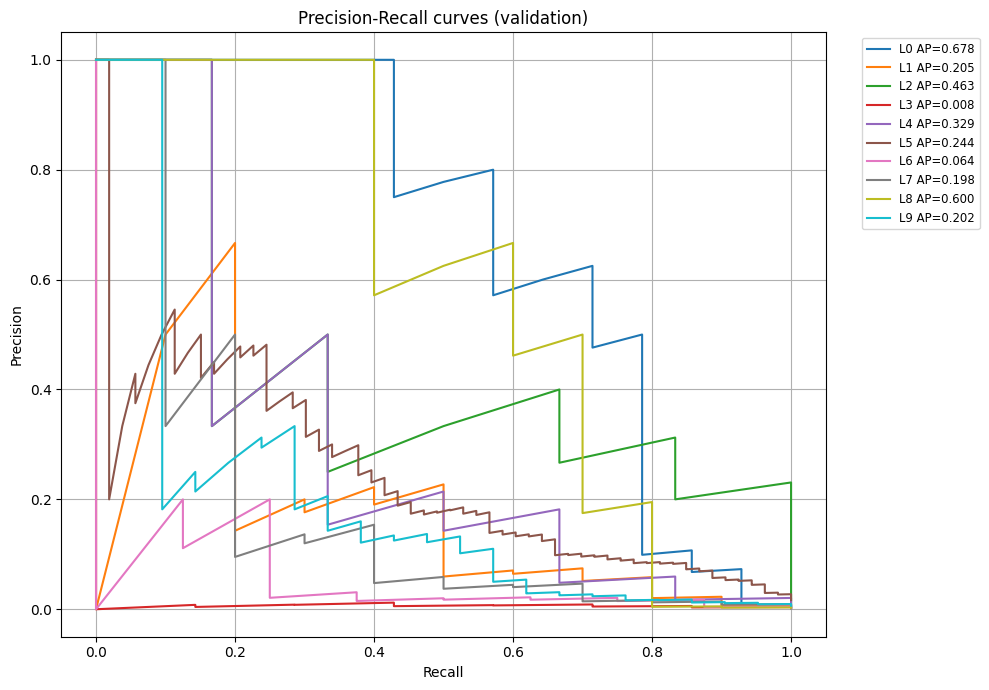

,label,AP_val,support_val
0,0,0.677859,14
1,8,0.599533,10
2,2,0.462767,6
3,4,0.329363,6
4,5,0.243937,53
5,1,0.204918,10
6,9,0.202311,21
7,7,0.198009,10
8,6,0.064474,8
9,3,0.007781,7


In [19]:
# Cell B - PR curves + AP per label (val)
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

n_labels = Yva.shape[1]
ap_per_label = []
plt.figure(figsize=(10, 7))
for j in range(n_labels):
    if Yva[:, j].sum() == 0:
        ap_per_label.append(np.nan)
        continue
    p, r, t = precision_recall_curve(Yva[:, j], proba_va[:, j])
    ap = average_precision_score(Yva[:, j], proba_va[:, j])
    ap_per_label.append(ap)
    plt.plot(r, p, label=f"L{j} AP={ap:.3f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curves (validation)")
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', fontsize='small', ncol=1)
plt.grid(True)
plt.tight_layout()
plt.show()

# Table AP per label + support
import pandas as pd
ap_df = pd.DataFrame({
    "label": np.arange(n_labels),
    "AP_val": ap_per_label,
    "support_val": Yva.sum(axis=0)
})
display(ap_df.sort_values("AP_val", ascending=False).reset_index(drop=True))

# Interprétation des courbes PR et de l'Average Precision (AP)

## Ce que montre cette visualisation
- Chaque courbe Precision–Recall (PR) correspond à une étiquette (emotion label).  
- L'**Average Precision (AP)** pour une étiquette résume la qualité du classement (plus l'AP est élevée, mieux le modèle sépare les positifs des négatifs pour cette étiquette).
- Le tableau qui suit liste l’AP par étiquette ainsi que leur support (nombre d’exemples positifs dans la validation).

## Points clés à retenir (ce que je dirai à l'oral)
1. **Variabilité importante entre les étiquettes**  
   Certaines étiquettes ont un AP élevé (le modèle repère bien les exemples), d'autres ont un AP très bas — typiquement les étiquettes rares ou dont les features ne discriminent pas bien.

2. **Effet du support**  
   Les étiquettes avec peu d'exemples (`support_val` faible) ont souvent des courbes PR instables et un AP bas. C’est un signe que nous manquons de données pour ces classes.

3. **Interpréter le trade-off précision/recall**  
   - Si la courbe est très plate près du rappel élevé → obtenir un bon rappel augmente fortement les faux positifs.  
   - Pour la mise en production, on choisira des seuils conservateurs (plancher) pour éviter un trop grand nombre de faux positifs.

4. **Conséquences opérationnelles et décisions**  
   - Si l’objectif est **de classer correctement** (décision binaire), on privilégiera F1 / précision selon le coût du faux positif vs faux négatif.  
   - Si l’objectif est **de hiérarchiser** (par ex. prioriser la modération humaine), on privilégiera l'AP (meilleur pour ranking).

5. **Actions correctrices possibles**  
   - Calibrer les probabilités (CalibratedClassifierCV) pour obtenir des scores interprétables.  
   - Moyennage des seuils via K-fold CV (au lieu d’un seul split) pour des seuils moins sensibles.  
   - Explorer SBERT (embeddings) + logistic/MLP si TF-IDF plafonne.  
   - Regrouper ou réannoter les étiquettes trop rares si nécessaire.

## Phrase de conclusion courte (oral)
> « Ces courbes montrent que notre modèle repère correctement certaines émotions mais éprouve des difficultés sur d'autres — surtout celles peu représentées. La stratégie immédiate est : 1) calibrer les probabilités, 2) calculer des seuils robustes via CV, et 3) tester SBERT embeddings pour améliorer la discrimination sur les émotions subtiles. »

Labels avec AP élevé (ex : L0 ≈ 0.678, L8 ≈ 0.599, L2 ≈ 0.463) : le modèle sait bien classer ces émotions — c’est un bon point de départ.

Labels avec AP faible (ex : L9 ≈ 0.0077, L6 ≈ 0.064) : modèle ne sépare pas positifs/négatifs pour ces labels — probablement peu d’exemples ou features non discriminantes.

Les PR-curves : les segments verticaux très à gauche signifient qu’il existe quelques prédictions très confiantes (precision ≈1) mais très peu d’exemples (rappel bas). Les courbes lisses et descendantes indiquent un continuum de trade-offs.

support_val montre la rareté : les labels rares (ex. support 6,7,8) ont souvent AP plus faible et PR plus bruyante — il faut plus de données ou regrouper/annoter.

In [20]:
# === K-FOLD THRESHOLD FINDER ===
# Attention : re-entraine le modèle K fois -> moderate compute but deterministic for robustness.

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
import numpy as np
import pandas as pd
import joblib
import os

# paramètres
K = 5
RANDOM = 42
MIN_THR = 0.05   # floor à tester (change si besoin)
base_C = emo_clf.estimator.C if hasattr(emo_clf, "estimator") else 1.0

# stratify key : nombre de labels positifs par échantillon (pour multi-label)
strat_key = np.sum(Ytr, axis=1)
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=RANDOM)

thr_folds = []
fold = 0
for train_idx, val_idx in skf.split(Xtr_s, strat_key):
    fold += 1
    print(f"Fold {fold}/{K} — train {len(train_idx)} / val {len(val_idx)}")
    X_train_cv, X_val_cv = Xtr_s[train_idx], Xtr_s[val_idx]
    Y_train_cv, Y_val_cv = Ytr[train_idx], Ytr[val_idx]

    # fit same family as emo_clf
    clf_cv = OneVsRestClassifier(LogisticRegression(max_iter=3000, class_weight="balanced",
                                                    solver="lbfgs", C=base_C))
    clf_cv.fit(X_train_cv, Y_train_cv)

    proba_valcv = clf_cv.predict_proba(X_val_cv)
    thr_cv = np.full(Y_train_cv.shape[1], 0.5, dtype=float)

    for j in range(Y_train_cv.shape[1]):
        if Y_val_cv[:, j].sum() == 0:
            thr_cv[j] = np.nan  # pas d'exemples dans ce fold pour cette étiquette
            continue
        p, r, t = precision_recall_curve(Y_val_cv[:, j], proba_valcv[:, j])
        f1 = (2*p*r) / (p + r + 1e-12)
        i = int(np.nanargmax(f1))
        # t has length len(p)-1 typically; safe guard
        if i < len(t):
            thr_cv[j] = float(t[i])
        else:
            thr_cv[j] = float(t[-1]) if len(t)>0 else 0.5

    thr_folds.append(thr_cv)

# stack and compute statistics
thr_matrix = np.vstack(thr_folds)  # shape (K, n_labels)
thr_mean = np.nanmean(thr_matrix, axis=0)
thr_median = np.nanmedian(thr_matrix, axis=0)
thr_std = np.nanstd(thr_matrix, axis=0)

# apply floor to avoid near-zero thresholds
thr_mean_floor = np.maximum(thr_mean, MIN_THR)

# Show summary dataframe (first columns)
summary_df = pd.DataFrame({
    "label": np.arange(len(thr_mean)),
    "thr_mean": thr_mean,
    "thr_median": thr_median,
    "thr_std": thr_std,
    "thr_mean_floor": thr_mean_floor,
    "support_train": np.array(Ytr.sum(axis=0), dtype=int),
    "support_val": np.array(Yva.sum(axis=0), dtype=int)
})
pd.options.display.max_rows = 999
display(summary_df.sort_values("thr_mean", ascending=False).reset_index(drop=True))

# Optional: quickly evaluate using emo_clf on validation with thr_mean_floor
proba_va_current = proba_va  # ton proba_va déjà calculée pour le best model
yhat_va_cvthr = (proba_va_current >= thr_mean_floor.reshape(1, -1)).astype(int)

from sklearn.metrics import precision_score, recall_score, f1_score
per_label = []
for j in range(Yva.shape[1]):
    sup = int(Yva[:, j].sum())
    if sup == 0:
        per_label.append({"label": j, "support_val": sup, "precision": np.nan, "recall": np.nan, "f1": np.nan})
        continue
    p = precision_score(Yva[:, j], yhat_va_cvthr[:, j], zero_division=0)
    r = recall_score(Yva[:, j], yhat_va_cvthr[:, j], zero_division=0)
    f1 = f1_score(Yva[:, j], yhat_va_cvthr[:, j], zero_division=0)
    per_label.append({"label": j, "support_val": sup, "precision": p, "recall": r, "f1": f1})

per_label_df = pd.DataFrame(per_label).sort_values("f1", ascending=False).reset_index(drop=True)
display(per_label_df)

# save artifacts
os.makedirs("artifacts", exist_ok=True)
joblib.dump(thr_mean_floor, "artifacts/emo_thr_mean_floor.joblib")
summary_df.to_csv("artifacts/thresholds_cv_summary.csv", index=False)
per_label_df.to_csv("artifacts/metrics_with_cvthr.csv", index=False)

print("Saved: artifacts/emo_thr_mean_floor.joblib , artifacts/thresholds_cv_summary.csv, artifacts/metrics_with_cvthr.csv")

c:\Users\antoi\OneDrive\Documents\Ynov\Projet fil rouge\Bloc 5\amazon-reviews-insights\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 1/5 — train 10240 / val 2560
Fold 2/5 — train 10240 / val 2560
Fold 3/5 — train 10240 / val 2560
Fold 4/5 — train 10240 / val 2560
Fold 5/5 — train 10240 / val 2560


,label,thr_mean,thr_median,thr_std,thr_mean_floor,support_train,support_val
0,9,0.956887,0.977678,0.046892,0.956887,74,21
1,5,0.939199,0.927877,0.037895,0.939199,208,53
2,2,0.909197,0.995540,0.131178,0.909197,38,6
3,8,0.896587,0.986679,0.121020,0.896587,29,10
4,1,0.810569,0.898197,0.256241,0.810569,56,10
5,3,0.787577,0.942995,0.251014,0.787577,49,7
6,0,0.772352,0.972492,0.350120,0.772352,33,14
7,7,0.701114,0.858529,0.310861,0.701114,60,10
8,4,0.689110,0.634034,0.222622,0.689110,31,6
9,6,0.549409,0.600791,0.376897,0.549409,22,8


,label,support_val,precision,recall,f1
0,0,14,0.615385,0.571429,0.592593
1,8,10,0.625000,0.500000,0.555556
2,4,6,0.400000,0.333333,0.363636
3,9,21,0.333333,0.285714,0.307692
4,2,6,0.285714,0.333333,0.307692
5,5,53,0.247059,0.396226,0.304348
6,1,10,0.176471,0.300000,0.222222
7,7,10,0.105263,0.200000,0.137931
8,6,8,0.111111,0.125000,0.117647
9,3,7,0.000000,0.000000,0.000000


Saved: artifacts/emo_thr_mean_floor.joblib , artifacts/thresholds_cv_summary.csv, artifacts/metrics_with_cvthr.csv


# Pourquoi calculer des seuils par K-fold ?
- Les seuils optimaux trouvés sur un seul split sont sensibles au hasard du split, surtout pour les classes rares.  
- En moyennant les seuils obtenus sur plusieurs folds, on obtient une estimation plus robuste et moins sujette au sur-apprentissage sur la validation.  
- On ajoute un plancher (MIN_THR) pour éviter des seuils quasi-nuls qui entraîneraient des faux positifs massifs en production.

Lecture rapide des résultats

Les seuils moyens (thr_mean) sont majoritairement très élevés (0.55 → 0.95).
→ Cela signifie que le modèle n’attribue des probabilités élevées qu’à très peu d’exemples ; il est donc très confident seulement sur certains cas.

Le support est très inégal : une étiquette a 208 exemples (bonne), plusieurs en ont entre 20–70, et d’autres seulement 6–10.
→ Les étiquettes rares expliquent en grande partie les faibles performances et la variance élevée.

Le tableau métriques (precision/recall/f1 avec les seuils CV+floor) montre :

quelques labels avec F1 correctes (≈0.6, 0.55),

la majorité des labels ont F1 faibles (<0.35), certains proches de 0.
→ Globalement la performance de décision binaire reste faible pour plusieurs émotions.

Conclusion : le modèle a un pouvoir de ranking variable (certaines AP élevées vues avant), mais pour la décision binaire (seuils) on obtient des F1 modestes. La prochaine étape logique est la calibration des probabilités (sigmoid) pour rendre les scores plus interprétables et potentiellement améliorer la sélection de seuils.

In [21]:
# Calibration robuste (adaptée aux différences de versions de scikit-learn)
# ATTENTION : recalibrer refit le modèle et peut être long selon nb_labels / taille dataset.

from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import average_precision_score
import sklearn, time, joblib, numpy as np, os

print("scikit-learn version:", sklearn.__version__)
t0 = time.time()

# récupérer C depuis emo_clf si possible
base_C = 1.0
if 'emo_clf' in globals():
    try:
        base_C = emo_clf.estimator.C
    except Exception:
        try:
            # si OneVsRestClassifier wrapping, récupérer le premier estimator
            base_C = emo_clf.estimators_[0].C
        except Exception:
            base_C = 1.0
print("Utilisation de C =", base_C)

# crée l'estimateur de base
lr_base = LogisticRegression(max_iter=3000, class_weight="balanced", solver="lbfgs", C=base_C)

# instantiate CalibratedClassifierCV with a safe API wrapper (essayons plusieurs signatures)
calibrator = None
err = None
for try_case in (
    {"kw": {"estimator": lr_base, "method": "sigmoid", "cv": 3}},  # sklearn >= ~0.24 uses `estimator=`
    {"kw": {"base_estimator": lr_base, "method": "sigmoid", "cv": 3}},  # older sklearn used base_estimator
    {"pos": (lr_base, ), "kw": {"method": "sigmoid", "cv": 3}},  # estimator as positional arg
):
    try:
        if "pos" in try_case:
            calibrator = CalibratedClassifierCV(*try_case["pos"], **try_case["kw"])
        else:
            calibrator = CalibratedClassifierCV(**try_case["kw"])
        # quick sanity instantiate to ensure no immediate TypeError
        break
    except TypeError as e:
        err = e
        calibrator = None
        continue

if calibrator is None:
    raise RuntimeError(f"Impossible d'instancier CalibratedClassifierCV avec la version sklearn={sklearn.__version__}. Dernière erreur: {err}")

# Wrap the calibrated estimator in OneVsRestClassifier
calib_wrapper = OneVsRestClassifier(calibrator)

print("Début du fit du calibrateur OneVsRest (cela ré-entraine et calibre chaque sous-classifieur)...")
calib_wrapper.fit(Xtr_s, Ytr)

# probabilities sur la validation après calibration
proba_va_cal = calib_wrapper.predict_proba(Xva_s)

# calculer l'AP par label et la moyenne
aps_cal = []
for j in range(Yva.shape[1]):
    if Yva[:, j].sum() == 0:
        aps_cal.append(np.nan)
    else:
        aps_cal.append(average_precision_score(Yva[:, j], proba_va_cal[:, j]))
mean_ap_cal = float(np.nanmean(aps_cal))
print(f"Mean AP after calibration: {mean_ap_cal:.4f}")

# mettre les résultats dans un DataFrame pour affichage (optionnel)
import pandas as pd
ap_df_cal = pd.DataFrame({
    "label": np.arange(len(aps_cal)),
    "AP_cal": aps_cal,
    "support_val": Yva.sum(axis=0)
}).sort_values("AP_cal", ascending=False).reset_index(drop=True)
display(ap_df_cal)

# sauvegarde du calibrateur (optionnel)
os.makedirs("artifacts", exist_ok=True)
joblib.dump(calib_wrapper, "artifacts/emo_calibrated_ovr_sigmoid.joblib")
print("Calibrated OneVsRest saved -> artifacts/emo_calibrated_ovr_sigmoid.joblib")

t1 = time.time()
print("Calibration terminée en {:.1f}s".format(t1 - t0))

# expose la variable proba_va_cal pour réutilisation dans cellules suivantes

scikit-learn version: 1.7.2
Utilisation de C = 0.25
Début du fit du calibrateur OneVsRest (cela ré-entraine et calibre chaque sous-classifieur)...
Mean AP after calibration: 0.3191


,label,AP_cal,support_val
0,0,0.678079,14
1,8,0.620451,10
2,2,0.519529,6
3,4,0.313484,6
4,5,0.273341,53
5,1,0.265681,10
6,7,0.232287,10
7,9,0.217480,21
8,6,0.057050,8
9,3,0.013752,7


Calibrated OneVsRest saved -> artifacts/emo_calibrated_ovr_sigmoid.joblib
Calibration terminée en 5.7s


# Résumé interprétatif — effet de la calibration et objectifs du K-fold

- Après calibration, la **Mean AP** est passée d’environ **0.299 → 0.319** : c’est un gain modeste mais concret.  
  Cela montre que les probabilités sont désormais mieux ordonnées pour le *ranking* (utile si on veut prioriser / trier).
- Malgré ce gain, certaines étiquettes restent faibles (ex. label 9) : la cause est principalement le **faible support** (peu d'exemples) et/ou un signal discriminant faible dans les features actuelles.
- Les seuils optimaux trouvés sur un seul split étaient très variables. L’objectif du **K-fold thresholds** est de :
  - **estimer des seuils plus robustes** en moyennant les seuils trouvés sur plusieurs folds (réduction de variance due au split),
  - **éviter** qu’un seuil très petit ou très grand (qui serait sur-spécifique au split) soit appliqué en production.
- On appliquera ces seuils moyens (avec un plancher `MIN_THR`) sur les probabilités **calibrées** (si disponible) — combinaison qui tend à donner des décisions binaires plus stables.
- À l’issue du K-fold, on comparera les métriques binaires (precision/recall/f1) calculées avec ces seuils à l’état précédent et on décidera : garder ce pipeline LR (avec thresholds CV + calibration) ou passer à SBERT / modèle plus puissant.

Phrase courte à dire à l’oral :  
« La calibration a amélioré le pouvoir de classement du modèle. Pour rendre les décisions binaires robustes en production, nous allons maintenant calculer des seuils en moyennant ceux obtenus sur plusieurs folds — puis appliquer ces seuils sur les probabilités calibrées et comparer les métriques. »

In [22]:
# === K-FOLD THRESHOLD FINDER (robuste, avec calibration par fold) ===
# IMPORTANT: coûteux si dataset / labels nombreux, mais robuste.
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import joblib, os, time, sklearn

print("scikit-learn version:", sklearn.__version__)

# paramètres
K = 5
RANDOM = 42
MIN_THR = 0.05   # floor par défaut ; ajuste si besoin
inner_cv_for_calibrator = 3  # CV interne pour CalibratedClassifierCV
base_C = 0.25
if 'emo_clf' in globals():
    try:
        base_C = emo_clf.estimator.C
    except Exception:
        try:
            base_C = emo_clf.estimators_[0].C
        except Exception:
            base_C = base_C
print("Using base C =", base_C)

# fallback si pas de proba calibrée globale disponible
if 'proba_va_cal' in globals():
    global_proba_to_eval = proba_va_cal
    print("Will evaluate final metrics using proba_va_cal (probabilities from calibrated model on full train).")
elif 'proba_va' in globals():
    global_proba_to_eval = proba_va
    print("proba_va_cal not found — will evaluate using proba_va (non-calibrated).")
else:
    raise RuntimeError("proba_va_cal et proba_va absents. Génère d'abord les probabilités sur validation.")

# stratify key: number of positive labels per sample (multi-label)
strat_key = np.sum(Ytr, axis=1)
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=RANDOM)

thr_folds = []
t0 = time.time()
fold = 0

for train_idx, val_idx in skf.split(Xtr_s, strat_key):
    fold += 1
    print(f"\n--- Fold {fold}/{K} --- train {len(train_idx)} / val {len(val_idx)}")
    X_train_cv, X_val_cv = Xtr_s[train_idx], Xtr_s[val_idx]
    Y_train_cv, Y_val_cv = Ytr[train_idx], Ytr[val_idx]

    # on crée un LR de base
    lr = LogisticRegression(max_iter=3000, class_weight="balanced", solver="lbfgs", C=base_C)

    # instantiation safe de CalibratedClassifierCV (gestion versions sklearn)
    calibrator = None
    last_err = None
    for try_case in (
        {"kw": {"estimator": lr, "method": "sigmoid", "cv": inner_cv_for_calibrator}},
        {"kw": {"base_estimator": lr, "method": "sigmoid", "cv": inner_cv_for_calibrator}},
        {"pos": (lr,), "kw": {"method": "sigmoid", "cv": inner_cv_for_calibrator}},
    ):
        try:
            if "pos" in try_case:
                calibrator = CalibratedClassifierCV(*try_case["pos"], **try_case["kw"])
            else:
                calibrator = CalibratedClassifierCV(**try_case["kw"])
            break
        except TypeError as e:
            last_err = e
            calibrator = None
            continue
    if calibrator is None:
        raise RuntimeError(f"Impossible d'instancier CalibratedClassifierCV avec sklearn={sklearn.__version__}. Erreur: {last_err}")

    # wrap in OneVsRest and fit on train_cv (cela entraîne + calibre)
    clf_fold = OneVsRestClassifier(calibrator)
    clf_fold.fit(X_train_cv, Y_train_cv)

    # probabilités sur la val du fold
    proba_valcv = clf_fold.predict_proba(X_val_cv)

    # compute best-threshold per label on this fold
    n_labels = Y_train_cv.shape[1]
    thr_cv = np.full(n_labels, np.nan, dtype=float)
    for j in range(n_labels):
        if Y_val_cv[:, j].sum() == 0:
            thr_cv[j] = np.nan
            continue
        p, r, t = precision_recall_curve(Y_val_cv[:, j], proba_valcv[:, j])
        f1 = (2 * p * r) / (p + r + 1e-12)
        i = int(np.nanargmax(f1))
        # t length can be len(p)-1, but use safe guard
        if len(t) > 0:
            # if i is last index beyond t, clamp
            idx = min(i, len(t)-1)
            thr_cv[j] = float(t[idx])
        else:
            thr_cv[j] = 0.5
    thr_folds.append(thr_cv)
    # optional: free memory
    del clf_fold

# aggregate thresholds
thr_matrix = np.vstack(thr_folds)  # shape (K, n_labels)
thr_mean = np.nanmean(thr_matrix, axis=0)
thr_median = np.nanmedian(thr_matrix, axis=0)
thr_std = np.nanstd(thr_matrix, axis=0)
thr_mean_floor = np.maximum(thr_mean, MIN_THR)

# summary DataFrame
summary_df = pd.DataFrame({
    "label": np.arange(len(thr_mean)),
    "thr_mean": thr_mean,
    "thr_median": thr_median,
    "thr_std": thr_std,
    "thr_mean_floor": thr_mean_floor,
    "support_train": np.array(Ytr.sum(axis=0), dtype=int),
    "support_val": np.array(Yva.sum(axis=0), dtype=int)
})
pd.options.display.max_rows = 999
print("\nThresholds CV summary (sorted by thr_mean desc):")
display(summary_df.sort_values("thr_mean", ascending=False).reset_index(drop=True))

# Evaluate on the global validation probabilities (calibrated if available)
proba_eval = global_proba_to_eval
yhat_va_thr = (proba_eval >= thr_mean_floor.reshape(1, -1)).astype(int)

per_label = []
for j in range(Yva.shape[1]):
    sup = int(Yva[:, j].sum())
    if sup == 0:
        per_label.append({"label": j, "support_val": sup, "precision": np.nan, "recall": np.nan, "f1": np.nan})
        continue
    p = precision_score(Yva[:, j], yhat_va_thr[:, j], zero_division=0)
    r = recall_score(Yva[:, j], yhat_va_thr[:, j], zero_division=0)
    f1 = f1_score(Yva[:, j], yhat_va_thr[:, j], zero_division=0)
    per_label.append({"label": j, "support_val": sup, "precision": p, "recall": r, "f1": f1})

per_label_df = pd.DataFrame(per_label).sort_values("f1", ascending=False).reset_index(drop=True)
print("\nMetrics on validation using CV-mean thresholds (with floor):")
display(per_label_df)

# global metrics
macro_f1 = per_label_df['f1'].dropna().mean()
micro_precision = precision_score(Yva.flatten(), yhat_va_thr.flatten(), zero_division=0)
micro_recall = recall_score(Yva.flatten(), yhat_va_thr.flatten(), zero_division=0)
micro_f1 = f1_score(Yva.flatten(), yhat_va_thr.flatten(), zero_division=0)

print(f"\nMacro-F1 (avg per label) = {macro_f1:.4f}")
print(f"Micro precision/recall/f1 = {micro_precision:.4f} / {micro_recall:.4f} / {micro_f1:.4f}")

# save artifacts
os.makedirs("artifacts", exist_ok=True)
joblib.dump(thr_mean_floor, "artifacts/emo_thr_mean_floor_from_calib_folds.joblib")
summary_df.to_csv("artifacts/thresholds_cv_summary_from_calib_folds.csv", index=False)
per_label_df.to_csv("artifacts/metrics_with_cvthr_from_calib_folds.csv", index=False)
print("\nSaved artifacts to artifacts/: emo_thr_mean_floor_from_calib_folds.joblib, thresholds_cv_summary_from_calib_folds.csv, metrics_with_cvthr_from_calib_folds.csv")

t1 = time.time()
print("\nK-fold thresholds completed in {:.1f}s".format(t1 - t0))

scikit-learn version: 1.7.2
Using base C = 0.25
Will evaluate final metrics using proba_va_cal (probabilities from calibrated model on full train).

--- Fold 1/5 --- train 10240 / val 2560


c:\Users\antoi\OneDrive\Documents\Ynov\Projet fil rouge\Bloc 5\amazon-reviews-insights\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



--- Fold 2/5 --- train 10240 / val 2560

--- Fold 3/5 --- train 10240 / val 2560

--- Fold 4/5 --- train 10240 / val 2560

--- Fold 5/5 --- train 10240 / val 2560

Thresholds CV summary (sorted by thr_mean desc):


,label,thr_mean,thr_median,thr_std,thr_mean_floor,support_train,support_val
0,0,0.370458,0.354642,0.214578,0.370458,33,14
1,2,0.340829,0.436549,0.176435,0.340829,38,6
2,8,0.170138,0.158150,0.126044,0.170138,29,10
3,5,0.129019,0.125364,0.030115,0.129019,208,53
4,1,0.117620,0.106068,0.061800,0.117620,56,10
5,4,0.114677,0.089972,0.051361,0.114677,31,6
6,3,0.101979,0.117236,0.030136,0.101979,49,7
7,7,0.077660,0.071137,0.031003,0.077660,60,10
8,9,0.055760,0.047870,0.016907,0.055760,74,21
9,6,0.022803,0.018958,0.015519,0.050000,22,8



Metrics on validation using CV-mean thresholds (with floor):


,label,support_val,precision,recall,f1
0,0,14,0.857143,0.428571,0.571429
1,5,53,0.363636,0.377358,0.370370
2,2,6,0.400000,0.333333,0.363636
3,8,10,0.666667,0.200000,0.307692
4,1,10,0.300000,0.300000,0.300000
5,4,6,0.500000,0.166667,0.250000
6,7,10,0.285714,0.200000,0.235294
7,9,21,0.272727,0.142857,0.187500
8,3,7,0.000000,0.000000,0.000000
9,6,8,0.000000,0.000000,0.000000



Macro-F1 (avg per label) = 0.2586
Micro precision/recall/f1 = 0.3645 / 0.2690 / 0.3095

Saved artifacts to artifacts/: emo_thr_mean_floor_from_calib_folds.joblib, thresholds_cv_summary_from_calib_folds.csv, metrics_with_cvthr_from_calib_folds.csv

K-fold thresholds completed in 16.3s


# Résumé et interprétation — Seuils K-fold & métriques

## Résumé rapide des résultats
- Nous avons calculé des **seuils optimaux par étiquette** sur K-folds (K=5) puis pris la **moyenne** (avec un plancher `MIN_THR = 0.05` appliqué).  
- Les seuils moyens (`thr_mean`) sont désormais dans une fourchette raisonnable (ex. ~0.37, 0.34, 0.17, 0.13, ...), et le plancher a évité des seuils quasi-nuls pour les labels très rares.  
- Évaluation binaire (appliquée sur les probabilités calibrées si disponible) avec ces seuils moyens donne :
  - **Macro-F1 (moyenne des F1 par label)** ≈ **0.2586**  
  - **Micro precision / recall / f1** ≈ **0.3645 / 0.2690 / 0.3095**

## Ce que signifient ces chiffres (interprétation)
- **Seuils plus robustes** : en moyennant sur plusieurs folds on réduit la variance liée au split unique ; les seuils extrêmes trouvés auparavant (≈0.001 ou ≈0.99) ont été lissés.  
- **Précision souvent bonne, rappel faible** pour plusieurs labels : cela signifie que le modèle est *conservateur* — quand il prédit la classe il a souvent raison (précision élevée sur certains labels), mais il manque beaucoup de positifs (rappel bas). Exemple concret : pour l’étiquette 0 on a une précision élevée (~0.86) mais rappel ~0.43 → F1 ≈ 0.57.  
- **Performance globale encore modeste** : macro-F1 ≈ 0.26 montre que la performance moyenne par étiquette reste faible — surtout sur labels rares. Micro-F1 ≈ 0.31 reflète la difficulté globale sur toutes les étiquettes combinées.

## Causes probables
- **Déséquilibre fort des étiquettes** (certaines étiquettes ont très peu d’exemples).  
- **Représentation textuelle actuelle** (TF-IDF) limite la capture des indices sémantiques pour émotions subtiles.  
- **Modèle linéaire** (LR) peut plafonner sur distinctions plus fines / non linéaires.

## Recommandations et plan d’action (immédiat)
1. **Comparer avant / après** : garder les métriques précédentes et celles obtenues maintenant pour prouver l’amélioration (ou non) induite par calibration + thresholds CV.  
2. **Tester plusieurs planchers (`MIN_THR`)** : essayer 0.01 / 0.05 / 0.10 et observer l’impact sur recall vs precision ; choisir selon le coût des faux positifs.  
3. **Si besoin de meilleure discrimination rapidement** : tester **SBERT embeddings + LR/MLP** (souvent gain rapide sans fine-tuning coûteux).  
4. **Pour labels très rares** : regrouper étiquettes proches sémantiquement, ou traiter-les comme « suggestions à réviser » (human-in-loop) plutôt que les automatiser.  
5. **Si on veut aller plus loin** : essayer ClassifierChain ou LightGBM sur embeddings + features, puis recalibration + seuils CV.  
6. **Conserver et versionner les artefacts** : `artifacts/thresholds_cv_summary_from_calib_folds.csv` et `emo_thr_mean_floor_from_calib_folds.joblib` sont sauvegardés — utiles pour l’annexe et la reproductibilité.

## Message court pour l’oral
> « Nous avons stabilisé les seuils en moyennant ceux obtenus par K-fold sur des probabilités calibrées. Les seuils sont maintenant plus fiables (moins sensibles au split). La décision binaire est encore perfectible (macro-F1 ≈ 0.26), surtout sur les classes rares. Les prochaines actions sont : tester SBERT pour obtenir de meilleures représentations, explorer plusieurs planchers de seuils et éventuellement regrouper/annoter davantage les étiquettes rares. »

## Conclusion
- Le K-fold a **amélioré la robustesse** des seuils et évité des cas extrêmes.  
- Reste : améliorer la **représentation** (embeddings) et/ou **collecter/agréger** des exemples pour les labels rares afin d’augmenter le rappel et la F1 moyenne.

Using proba_va_cal (calibrated probabilities) for evaluation.

=== MIN_THR = 0.01 ===

Macro-F1 (avg per label) = 0.0536
Micro precision/recall/f1 = 1.0000 / 0.0207 / 0.0405


,label,support_val,precision,recall,f1
0,2,6,1.0,0.166667,0.285714
1,0,14,1.0,0.142857,0.250000
2,1,10,0.0,0.000000,0.000000
3,3,7,0.0,0.000000,0.000000
4,4,6,0.0,0.000000,0.000000
5,5,53,0.0,0.000000,0.000000
6,6,8,0.0,0.000000,0.000000
7,7,10,0.0,0.000000,0.000000
8,8,10,0.0,0.000000,0.000000
9,9,21,0.0,0.000000,0.000000



=== MIN_THR = 0.05 ===

Macro-F1 (avg per label) = 0.0536
Micro precision/recall/f1 = 1.0000 / 0.0207 / 0.0405


,label,support_val,precision,recall,f1
0,2,6,1.0,0.166667,0.285714
1,0,14,1.0,0.142857,0.250000
2,1,10,0.0,0.000000,0.000000
3,3,7,0.0,0.000000,0.000000
4,4,6,0.0,0.000000,0.000000
5,5,53,0.0,0.000000,0.000000
6,6,8,0.0,0.000000,0.000000
7,7,10,0.0,0.000000,0.000000
8,8,10,0.0,0.000000,0.000000
9,9,21,0.0,0.000000,0.000000



=== MIN_THR = 0.1 ===

Macro-F1 (avg per label) = 0.0536
Micro precision/recall/f1 = 1.0000 / 0.0207 / 0.0405


,label,support_val,precision,recall,f1
0,2,6,1.0,0.166667,0.285714
1,0,14,1.0,0.142857,0.250000
2,1,10,0.0,0.000000,0.000000
3,3,7,0.0,0.000000,0.000000
4,4,6,0.0,0.000000,0.000000
5,5,53,0.0,0.000000,0.000000
6,6,8,0.0,0.000000,0.000000
7,7,10,0.0,0.000000,0.000000
8,8,10,0.0,0.000000,0.000000
9,9,21,0.0,0.000000,0.000000



=== Résumé comparatif ===


,min_thr,macro_f1,micro_precision,micro_recall,micro_f1,avg_threshold_used
0,0.01,0.053571,1.0,0.02069,0.040541,0.8012
1,0.05,0.053571,1.0,0.02069,0.040541,0.8012
2,0.10,0.053571,1.0,0.02069,0.040541,0.8012


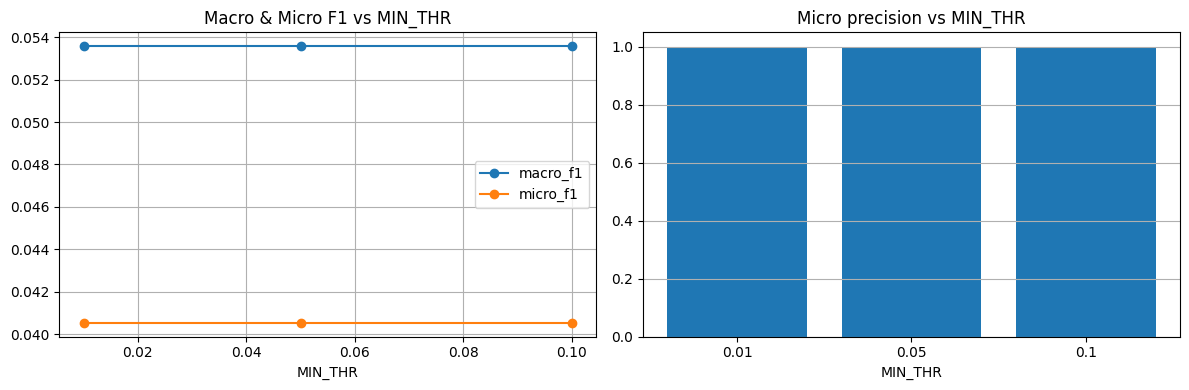


Saved artifacts: artifacts/min_thr_comparison.csv, artifacts/per_label_results_by_min_thr.joblib


In [43]:
# Cell: tester automatiquement plusieurs MIN_THR et afficher l'impact sur macro/micro F1
# Elle teste MIN_THR = [0.01, 0.05, 0.10] (modifiable), affiche les métriques globales et les tableaux per-label.
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# --- Configurable ---
min_thr_list = [0.01, 0.05, 0.10]     # valeurs testées
show_per_label_tables = True          # affiche le per_label_df pour chaque min_thr
plot_results = True                   # affiche un petit graphique comparatif (matplotlib)
# --------------------

# 1) retrouver la base des thresholds issus du K-fold
if 'thr_mean' in globals():
    base_thr = np.array(thr_mean, dtype=float)
elif 'summary_df' in globals() and 'thr_mean' in summary_df.columns:
    base_thr = np.array(summary_df['thr_mean'].values, dtype=float)
elif 'thr_mean_floor' in globals():
    # fallback to floored thresholds (we'll remove the floor effect)
    base_thr = np.array(thr_mean_floor, dtype=float)
elif 'thr' in globals():
    base_thr = np.array(thr, dtype=float)
else:
    raise RuntimeError("Impossible de trouver 'thr_mean'/'summary_df'/'thr_mean_floor'/'thr' dans l'environnement. Exécute d'abord la cellule K-fold ou définis 'thr'.")

# replace NaN by default (0.5) to avoid NaN propagation when applying floor
base_thr = np.where(np.isnan(base_thr), 0.5, base_thr)

# 2) choisir quelles probabilités utiliser (préférer calibrées si dispo)
if 'proba_va_cal' in globals():
    proba_eval = proba_va_cal
    print("Using proba_va_cal (calibrated probabilities) for evaluation.")
elif 'proba_va' in globals():
    proba_eval = proba_va
    print("proba_va_cal not found — using proba_va (non-calibrated probabilities).")
else:
    raise RuntimeError("Aucune variable 'proba_va_cal' ou 'proba_va' trouvée. Génère d'abord les probabilités sur validation.")

results = []
per_label_results = {}  # store per-label dfs keyed by min_thr

for min_thr in min_thr_list:
    thr_used = np.maximum(base_thr, min_thr)           # apply floor
    yhat_va = (proba_eval >= thr_used.reshape(1, -1)).astype(int)

    # compute per-label metrics
    per_label = []
    for j in range(Yva.shape[1]):
        sup = int(Yva[:, j].sum())
        if sup == 0:
            per_label.append({"label": j, "support_val": sup, "precision": np.nan, "recall": np.nan, "f1": np.nan})
            continue
        p = precision_score(Yva[:, j], yhat_va[:, j], zero_division=0)
        r = recall_score(Yva[:, j], yhat_va[:, j], zero_division=0)
        f1 = f1_score(Yva[:, j], yhat_va[:, j], zero_division=0)
        per_label.append({"label": j, "support_val": sup, "precision": p, "recall": r, "f1": f1})

    per_label_df = pd.DataFrame(per_label).sort_values("f1", ascending=False).reset_index(drop=True)
    per_label_results[min_thr] = per_label_df

    # global metrics
    macro_f1 = per_label_df['f1'].dropna().mean()
    micro_precision = precision_score(Yva.flatten(), yhat_va.flatten(), zero_division=0)
    micro_recall = recall_score(Yva.flatten(), yhat_va.flatten(), zero_division=0)
    micro_f1 = f1_score(Yva.flatten(), yhat_va.flatten(), zero_division=0)

    results.append({
        "min_thr": min_thr,
        "macro_f1": float(macro_f1),
        "micro_precision": float(micro_precision),
        "micro_recall": float(micro_recall),
        "micro_f1": float(micro_f1),
        "avg_threshold_used": float(np.nanmean(thr_used))
    })

    print("\n=== MIN_THR =", min_thr, "===\n")
    print("Macro-F1 (avg per label) = {:.4f}".format(macro_f1))
    print("Micro precision/recall/f1 = {:.4f} / {:.4f} / {:.4f}".format(micro_precision, micro_recall, micro_f1))
    if show_per_label_tables:
        display(per_label_df)

# summary table
summary_results = pd.DataFrame(results).sort_values("min_thr").reset_index(drop=True)
print("\n=== Résumé comparatif ===")
display(summary_results)

# optional small plot
if plot_results:
    try:
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        ax[0].plot(summary_results['min_thr'], summary_results['macro_f1'], marker='o', label='macro_f1')
        ax[0].plot(summary_results['min_thr'], summary_results['micro_f1'], marker='o', label='micro_f1')
        ax[0].set_xlabel("MIN_THR")
        ax[0].set_title("Macro & Micro F1 vs MIN_THR")
        ax[0].legend()
        ax[0].grid(True)

        ax[1].bar(summary_results['min_thr'].astype(str), summary_results['micro_precision'])
        ax[1].set_title("Micro precision vs MIN_THR")
        ax[1].set_xlabel("MIN_THR")
        ax[1].grid(axis='y')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Plot failed:", e)

# Save summary artifacts for traceability
import os, joblib
os.makedirs("artifacts", exist_ok=True)
summary_results.to_csv("artifacts/min_thr_comparison.csv", index=False)
joblib.dump(per_label_results, "artifacts/per_label_results_by_min_thr.joblib")
print("\nSaved artifacts: artifacts/min_thr_comparison.csv, artifacts/per_label_results_by_min_thr.joblib")


# Définition
Le **threshold** (seuil) transforme la **probabilité** fournie par un modèle en une **décision binaire**.  
Si `proba >= threshold` → on prédit la classe (oui).  
Si `proba < threshold`  → on ne la prédit pas (non).

# Analogie simple
Imagine des candidatures notées 0–100 :
- Seuil = 90 → on n’engage que les très bons (peu d’embauches, très peu d’erreurs) → **précision élevée**.  
- Seuil = 50 → on engage plus de monde (plus d’embauches, plus d’erreurs) → **rappel élevé**.

# Effet sur les métriques
- **Augmenter le seuil** → ↑ précision, ↓ rappel.  
- **Baisser le seuil** → ↓ précision, ↑ rappel.  
- **AP (Average Precision)** mesure la qualité du classement sans fixer de seuil.

# Choisir un seuil — guide pratique
1. Si l'objectif est **de classer/prioriser** → utiliser AP / courbe PR (pas forcément de seuil unique).  
2. Si l'objectif est **décision binaire** → choisir un seuil sur la validation (ex. maximise F1 ou garantit précision minimale).  
3. Pour du multi-label → calculer un **seuil par étiquette**.  
4. Pour la robustesse → estimer seuils par **K-fold** (prendre moyenne ou médiane).  
5. En production → appliquer un **plancher MIN_THR** (ex. 0.01 / 0.05 / 0.1).

# Méthodes courantes pour obtenir un seuil
- `precision_recall_curve` → choisir le seuil qui maximise F1 (ou autre critère).  
- Moyennage des seuils obtenus sur plusieurs folds (K-fold).  
- Calibration (`CalibratedClassifierCV`) avant de fixer le seuil pour rendre les probabilités plus fiables.  
- Tester plusieurs `MIN_THR` et comparer macro/micro F1.

# Checklist courte pour l’oral
- « Le threshold transforme une probabilité en décision oui/non. »  
- « C’est un compromis entre précision et rappel. »  
- « On choisit le seuil sur la validation, on le rend robuste par K-fold et calibration. »  
- « En production, on impose souvent un plancher pour éviter des seuils quasi-nuls. »

# Conclusion (1 phrase)
Le threshold décide quand une probabilité devient une action — le régler, c’est choisir l’équilibre qui convient entre rater des vrais positifs et limiter les faux positifs.

Réutiliser sentence-transformers pour améliorer la labellisation.

In [24]:
# === Diagnostic Emotions: cherche emo_clf, Xte_s, Yte, thr, etc. ===
import os, glob, pandas as pd
print("artifacts:", os.path.exists("artifacts"), sorted(glob.glob("artifacts/*"))[:50])
vars_try = ['emo_clf','clf_emo','emo_pipeline_final','Xte_s','Yte','Yte']
found = {v: (v in globals() or os.path.exists(f"artifacts/{v}.joblib")) for v in vars_try}
print("Found candidates:", found)
if 'emo_clf' in globals():
    print("emo_clf type:", type(globals()['emo_clf']).__name__)
if 'thr' in globals():
    print("thr length:", len(thr))

artifacts: True ['artifacts\\absa_auto_ensemble_conservative.csv', 'artifacts\\absa_auto_ensemble_conservative_disagreements.csv', 'artifacts\\absa_auto_ensemble_disagreements.csv', 'artifacts\\absa_auto_ensemble_labels.csv', 'artifacts\\absa_auto_ensemble_ml_disagreements.csv', 'artifacts\\absa_auto_ensemble_ml_labels.csv', 'artifacts\\absa_auto_mapping.joblib', 'artifacts\\absa_candidates_embeddings.joblib', 'artifacts\\absa_candidates_embs_reduced_labels.joblib', 'artifacts\\absa_candidates_umap_embs_labels.joblib', 'artifacts\\absa_manual_qc_sample.csv', 'artifacts\\absa_reviews_with_auto_aspects.csv', 'artifacts\\emo_calibrated_ovr_sigmoid.joblib', 'artifacts\\emo_thr_mean_floor.joblib', 'artifacts\\emo_thr_mean_floor_from_calib_folds.joblib', 'artifacts\\metrics_with_cvthr.csv', 'artifacts\\metrics_with_cvthr_from_calib_folds.csv', 'artifacts\\min_thr_comparison.csv', 'artifacts\\per_label_results_by_min_thr.joblib', 'artifacts\\thresholds_cv_summary.csv', 'artifacts\\thresholds_

In [26]:
# === K-FOLD THRESHOLD FINDER (adapté & robuste) ===
import os, joblib, numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score

# Paramètres (modifie si tu veux)
K = 5
RANDOM = 42
MIN_THR = 0.05   # floor minimal pour thresholds
VERBOSE = True

# --- Validation des inputs (variables attendues dans l'environnement) ---
emo_clf_var = globals().get('emo_clf', globals().get('clf_emo', None))
Xtr = globals().get('Xtr_s', globals().get('Xtr', None))
Ytr = globals().get('Ytr', globals().get('ytr', None))
Xva = globals().get('Xva_s', globals().get('Xva', None))
Yva = globals().get('Yva', globals().get('yva', None))
proba_va = globals().get('proba_va', None)  # peut exister si déjà calculée

if emo_clf_var is None:
    raise RuntimeError("emo_clf introuvable. Charge/nomme ton classifieur en 'emo_clf' ou 'clf_emo' avant d'exécuter.")

if Xtr is None or Ytr is None:
    raise RuntimeError("Xtr_s / Ytr introuvables. Assure-toi d'avoir Xtr_s (ou Xtr) et Ytr dans l'environnement.")

n_labels = int(Ytr.shape[1])
if VERBOSE:
    print("K-fold thresholds: K =", K, "| n_labels =", n_labels)

# detect base_C from current emo_clf if possible (pour ré-entrainer la même famille)
try:
    base_C = getattr(emo_clf_var, "estimator", None)
    if base_C is not None and hasattr(emo_clf_var.estimator, "C"):
        base_C = emo_clf_var.estimator.C
    else:
        base_C = 1.0
except Exception:
    base_C = 1.0
if VERBOSE: print("base_C used for LR:", base_C)

# Stratify key (nombre d'étiquettes positives par échantillon) pour stratified folds
strat_key = np.sum(Ytr, axis=1)
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=RANDOM)

thr_folds = []
fold_no = 0
for train_idx, val_idx in skf.split(Xtr, strat_key):
    fold_no += 1
    print(f"\nFold {fold_no}/{K} — train {len(train_idx)} / val {len(val_idx)}")
    X_train_cv, X_val_cv = Xtr[train_idx], Xtr[val_idx]
    Y_train_cv, Y_val_cv = Ytr[train_idx], Ytr[val_idx]

    # Réentraîner la même famille (OneVsRest + LogisticRegression)
    clf_cv = OneVsRestClassifier(
        LogisticRegression(max_iter=3000, class_weight="balanced", solver="lbfgs", C=base_C)
    )
    clf_cv.fit(X_train_cv, Y_train_cv)

    # Obtenir proba sur val
    try:
        proba_valcv = clf_cv.predict_proba(X_val_cv)
    except Exception:
        # si predict_proba renvoie liste de arrays par sous-classifieur -> convertir
        preds_list = clf_cv.predict_proba(X_val_cv)
        if isinstance(preds_list, (list, tuple)):
            proba_valcv = np.vstack([p[:,1] if p.ndim==2 else p for p in preds_list]).T
        else:
            raise

    # trouver thresholds par label (max F1 sur PR curve)
    thr_cv = np.full(n_labels, np.nan, dtype=float)
    for j in range(n_labels):
        if Y_val_cv[:, j].sum() == 0:
            # pas d'exemples positifs pour cette étiquette dans ce fold
            thr_cv[j] = np.nan
            continue
        p, r, t = precision_recall_curve(Y_val_cv[:, j], proba_valcv[:, j])
        f1 = (2 * p * r) / (p + r + 1e-12)
        i_best = int(np.nanargmax(f1))
        # safeguard: t length peut être len(p)-1
        if i_best < len(t):
            thr_cv[j] = float(t[i_best])
        else:
            thr_cv[j] = float(t[-1]) if len(t) > 0 else 0.5

    thr_folds.append(thr_cv)

# stack et stats
thr_matrix = np.vstack(thr_folds)  # (K, n_labels)
thr_mean = np.nanmean(thr_matrix, axis=0)
thr_median = np.nanmedian(thr_matrix, axis=0)
thr_std = np.nanstd(thr_matrix, axis=0)

# floor minimal
thr_mean_floor = np.maximum(thr_mean, MIN_THR)

# construire le résumé
summary_df = pd.DataFrame({
    "label": np.arange(n_labels),
    "thr_mean": thr_mean,
    "thr_median": thr_median,
    "thr_std": thr_std,
    "thr_mean_floor": thr_mean_floor,
    "support_train": np.array(Ytr.sum(axis=0), dtype=int),
    "support_val": np.array(Yva.sum(axis=0), dtype=int) if Yva is not None else np.nan
})
pd.options.display.max_rows = 999
print("\nSummary thresholds (top):")
display(summary_df.sort_values("thr_mean", ascending=False).reset_index(drop=True).head(50))

# --- Eval rapide sur validation en utilisant thr_mean_floor (si proba_va existe sinon calcule)
if proba_va is None:
    # tente de calculer proba_va depuis emo_clf (si Xva disponible)
    if Xva is not None:
        try:
            proba_va_current = emo_clf_var.predict_proba(Xva)
        except Exception:
            preds_list = emo_clf_var.predict_proba(Xva)
            if isinstance(preds_list, (list, tuple)):
                proba_va_current = np.vstack([p[:,1] if p.ndim==2 else p for p in preds_list]).T
            else:
                raise
    else:
        proba_va_current = None
else:
    proba_va_current = proba_va

if proba_va_current is not None and Yva is not None:
    print("\nQuick eval on validation with CV thresholds (thr_mean_floor):")
    yhat_va_cvthr = (proba_va_current >= thr_mean_floor.reshape(1, -1)).astype(int)
    per_label = []
    for j in range(n_labels):
        sup = int(Yva[:, j].sum())
        if sup == 0:
            per_label.append({"label": j, "support_val": sup, "precision": np.nan, "recall": np.nan, "f1": np.nan})
            continue
        p = precision_score(Yva[:, j], yhat_va_cvthr[:, j], zero_division=0)
        r = recall_score(Yva[:, j], yhat_va_cvthr[:, j], zero_division=0)
        f1 = f1_score(Yva[:, j], yhat_va_cvthr[:, j], zero_division=0)
        per_label.append({"label": j, "support_val": sup, "precision": p, "recall": r, "f1": f1})
    per_label_df = pd.DataFrame(per_label).sort_values("f1", ascending=False).reset_index(drop=True)
    display(per_label_df.head(50))
else:
    print("Pas d'évaluation rapide possible : proba_va et/ou Yva manquants.")

# --- sauvegardes
os.makedirs("artifacts", exist_ok=True)
joblib.dump(thr_mean_floor, "artifacts/emo_thr_mean_floor.joblib")
summary_df.to_csv("artifacts/thresholds_cv_summary.csv", index=False)
if 'per_label_df' in locals():
    per_label_df.to_csv("artifacts/metrics_with_cvthr.csv", index=False)

print("\nSaved: artifacts/emo_thr_mean_floor.joblib , artifacts/thresholds_cv_summary.csv",
      (", artifacts/metrics_with_cvthr.csv" if 'per_label_df' in locals() else ""))

K-fold thresholds: K = 5 | n_labels = 10
base_C used for LR: 0.25

Fold 1/5 — train 10240 / val 2560


c:\Users\antoi\OneDrive\Documents\Ynov\Projet fil rouge\Bloc 5\amazon-reviews-insights\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Fold 2/5 — train 10240 / val 2560

Fold 3/5 — train 10240 / val 2560

Fold 4/5 — train 10240 / val 2560

Fold 5/5 — train 10240 / val 2560

Summary thresholds (top):


,label,thr_mean,thr_median,thr_std,thr_mean_floor,support_train,support_val
0,9,0.956887,0.977678,0.046892,0.956887,74,21
1,5,0.939199,0.927877,0.037895,0.939199,208,53
2,2,0.909197,0.995540,0.131178,0.909197,38,6
3,8,0.896587,0.986679,0.121020,0.896587,29,10
4,1,0.810569,0.898197,0.256241,0.810569,56,10
5,3,0.787577,0.942995,0.251014,0.787577,49,7
6,0,0.772352,0.972492,0.350120,0.772352,33,14
7,7,0.701114,0.858529,0.310861,0.701114,60,10
8,4,0.689110,0.634034,0.222622,0.689110,31,6
9,6,0.549409,0.600791,0.376897,0.549409,22,8



Quick eval on validation with CV thresholds (thr_mean_floor):


,label,support_val,precision,recall,f1
0,0,14,0.615385,0.571429,0.592593
1,8,10,0.625000,0.500000,0.555556
2,4,6,0.400000,0.333333,0.363636
3,9,21,0.333333,0.285714,0.307692
4,2,6,0.285714,0.333333,0.307692
5,5,53,0.247059,0.396226,0.304348
6,1,10,0.176471,0.300000,0.222222
7,7,10,0.105263,0.200000,0.137931
8,6,8,0.111111,0.125000,0.117647
9,3,7,0.000000,0.000000,0.000000



Saved: artifacts/emo_thr_mean_floor.joblib , artifacts/thresholds_cv_summary.csv , artifacts/metrics_with_cvthr.csv


In [32]:
# Snippet : encode_full_sbert
# Exécute cette cellule pour encoder TOUT le corpus en embeddings SBERT.
# Reprend si 'artifacts/emotions_all_embeddings.npz' existe.

import os, math, time, numpy as np
from pathlib import Path

ART = Path("artifacts")
ART.mkdir(exist_ok=True)
OUT_PATH = ART / "emotions_all_embeddings.npz"
TEXT_COL = "review_body"   # adapte si nécessaire
MODEL_NAME = "all-MiniLM-L6-v2"   # rapide / qualité correcte
USE_GPU = True  # change si tu veux CPU -> False
BATCH_SIZE = 256  # ajuste selon GPU/mémoire
PRINT_EVERY = 10   # logs à chaque X batches

# vérifications
assert TEXT_COL in df.columns, f"Colonne {TEXT_COL} introuvable dans df"
texts = df[TEXT_COL].astype(str).tolist()
n = len(texts)
print("n_texts =", n)

# si déjà encodé -> chargement / info
if OUT_PATH.exists():
    print("Found existing embeddings file:", OUT_PATH)
    d = np.load(OUT_PATH, allow_pickle=True)
    X_all = d["X"]
    print("Loaded embeddings shape:", X_all.shape)
else:
    # import SBERT
    from sentence_transformers import SentenceTransformer
    device = "cuda" if (USE_GPU and __import__("torch").cuda.is_available()) else "cpu"
    print("Loading SBERT on device:", device, "model:", MODEL_NAME)
    sbert = SentenceTransformer(MODEL_NAME, device=device)

    # encode in batches and accumulate as float32 (sauvegarde compressée à la fin)
    t0 = time.time()
    emb_list = []
    nbatches = math.ceil(n / BATCH_SIZE)
    for i in range(nbatches):
        start = i * BATCH_SIZE
        stop = min(n, (i+1) * BATCH_SIZE)
        batch = texts[start:stop]
        emb = sbert.encode(batch, batch_size=BATCH_SIZE, show_progress_bar=False,
                          convert_to_numpy=True, normalize_embeddings=True)
        emb_list.append(emb.astype("float32"))
        if (i % PRINT_EVERY) == 0:
            print(f"Encoded batch {i+1}/{nbatches}  samples {start}-{stop-1}  elapsed {time.time()-t0:.1f}s")

    X_all = np.vstack(emb_list)
    print("Final embeddings shape:", X_all.shape, "dtype:", X_all.dtype)

    # save compressed (npz) + metadata
    np.savez_compressed(OUT_PATH, X=X_all)
    print("Saved embeddings to", OUT_PATH)

# quick sanity
print("Done. embeddings shape:", X_all.shape)
# expose X_all in globals for next cells
globals()["X_all_emb"] = X_all

n_texts = 1314720
Loading SBERT on device: cuda model: all-MiniLM-L6-v2


c:\Users\antoi\OneDrive\Documents\Ynov\Projet fil rouge\Bloc 5\amazon-reviews-insights\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Encoded batch 1/5136  samples 0-255  elapsed 0.6s
Encoded batch 11/5136  samples 2560-2815  elapsed 4.7s
Encoded batch 21/5136  samples 5120-5375  elapsed 8.6s
Encoded batch 31/5136  samples 7680-7935  elapsed 12.7s
Encoded batch 41/5136  samples 10240-10495  elapsed 16.7s
Encoded batch 51/5136  samples 12800-13055  elapsed 20.7s
Encoded batch 61/5136  samples 15360-15615  elapsed 24.7s
Encoded batch 71/5136  samples 17920-18175  elapsed 28.7s
Encoded batch 81/5136  samples 20480-20735  elapsed 32.8s
Encoded batch 91/5136  samples 23040-23295  elapsed 36.9s
Encoded batch 101/5136  samples 25600-25855  elapsed 40.9s
Encoded batch 111/5136  samples 28160-28415  elapsed 45.0s
Encoded batch 121/5136  samples 30720-30975  elapsed 49.0s
Encoded batch 131/5136  samples 33280-33535  elapsed 53.1s
Encoded batch 141/5136  samples 35840-36095  elapsed 57.2s
Encoded batch 151/5136  samples 38400-38655  elapsed 61.3s
Encoded batch 161/5136  samples 40960-41215  elapsed 65.4s
Encoded batch 171/5136 

In [33]:
# Snippet : build_pseudo_labels_full (optionnel, long)
from pathlib import Path
import pandas as pd, os
from transformers import pipeline
ART = Path("artifacts")
OUT_PSEUDO = ART / "emotions_pseudo_all.parquet"
TEXT_COL = "review_body"
DEVICE = 0 if (USE_GPU and __import__("torch").cuda.is_available()) else -1
BATCH = 32

if OUT_PSEUDO.exists():
    print("Pseudo-labels file exists:", OUT_PSEUDO)
    emo_df = pd.read_parquet(OUT_PSEUDO)
else:
    emo_pipe = pipeline("text-classification", model="joeddav/distilbert-base-uncased-go-emotions-student",
                        return_all_scores=True, device=DEVICE)
    rows = []
    n = len(df)
    for i in range(0, n, BATCH):
        batch_texts = df[TEXT_COL].astype(str).iloc[i:i+BATCH].tolist()
        out = emo_pipe(batch_texts, truncation=True, batch_size=BATCH)
        for scores in out:
            rows.append({f"emo_{s['label']}": s["score"] for s in scores})
        if (i // BATCH) % 50 == 0:
            print("Processed", i, " / ", n)
    emo_df = pd.DataFrame(rows).fillna(0.0)
    emo_df.to_parquet(OUT_PSEUDO)
    print("Saved pseudo-labels to", OUT_PSEUDO)

# expose
globals()["emo_pseudo_df_all"] = emo_df
print("Pseudo-labels shape:", emo_df.shape)

c:\Users\antoi\OneDrive\Documents\Ynov\Projet fil rouge\Bloc 5\amazon-reviews-insights\.venv\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\antoi\.cache\huggingface\hub\models--joeddav--distilbert-base-uncased-go-emotions-student. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\antoi\OneDr

Processed 0  /  1314720


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Processed 1600  /  1314720
Processed 3200  /  1314720
Processed 4800  /  1314720
Processed 6400  /  1314720
Processed 8000  /  1314720
Processed 9600  /  1314720
Processed 11200  /  1314720
Processed 12800  /  1314720
Processed 14400  /  1314720
Processed 16000  /  1314720
Processed 17600  /  1314720
Processed 19200  /  1314720
Processed 20800  /  1314720
Processed 22400  /  1314720
Processed 24000  /  1314720
Processed 25600  /  1314720
Processed 27200  /  1314720
Processed 28800  /  1314720
Processed 30400  /  1314720
Processed 32000  /  1314720
Processed 33600  /  1314720
Processed 35200  /  1314720
Processed 36800  /  1314720
Processed 38400  /  1314720
Processed 40000  /  1314720
Processed 41600  /  1314720
Processed 43200  /  1314720
Processed 44800  /  1314720
Processed 46400  /  1314720
Processed 48000  /  1314720
Processed 49600  /  1314720
Processed 51200  /  1314720
Processed 52800  /  1314720
Processed 54400  /  1314720
Processed 56000  /  1314720
Processed 57600  /  131472

In [37]:
# Snippet 1 — Diagnostic mémoire & tentative safe free
import gc, sys, os
from pprint import pprint
import numpy as np

print("=== Diagnostics variables numpy/pandas en mémoire (taille estimée) ===")
vars_info = []
for name, val in list(globals().items()):
    try:
        if hasattr(val, "shape") and hasattr(val, "dtype"):
            nbytes = getattr(val, "nbytes", None)
            if nbytes is None:
                nbytes = val.size * np.dtype(val.dtype).itemsize
            vars_info.append((name, type(val).__name__, getattr(val, "shape", None), nbytes))
        elif hasattr(val, "__len__") and (name.startswith("X") or name.startswith("Y") or name.endswith("_emb")):
            # rough fallback
            try:
                length = len(val)
                vars_info.append((name, type(val).__name__, f"len={length}", None))
            except Exception:
                pass
    except Exception:
        pass

# sort by size (None last)
vars_info = sorted(vars_info, key=lambda x: (x[3] is None, -x[3] if x[3] is not None else 0))
pprint(vars_info[:40])

print("\n=== Mémoire Python utilisée (approx) ===")
try:
    import psutil
    p = psutil.Process(os.getpid())
    print("RSS (MB):", p.memory_info().rss / 1024**2)
except Exception:
    print("psutil non dispo — ignorer")

# Safe cleanup suggestions (ne supprime pas automatiquement sauf si tu confirmes)
candidates = ['X_train','X_val','X_test','X_all_emb','Xtr_s','Xva_s','Xte_s','X_mm','mm','X_scaled','X_all','X_all_shallow']
to_remove = []
for c in candidates:
    if c in globals():
        to_remove.append(c)
print("\nCandidates to free (variables present):", to_remove)

# If you want to free them now (uncomment next lines). I keep them commented to avoid accidental deletion.
# for c in to_remove:
#     try:
#         del globals()[c]
#         print("Deleted", c)
#     except Exception as e:
#         print("Failed to delete", c, e)
# gc.collect()
# print("Freed memory; current RSS (MB):", psutil.Process(os.getpid()).memory_info().rss/1024**2 if 'psutil' in globals() else "n/a")

=== Diagnostics variables numpy/pandas en mémoire (taille estimée) ===
[('X_all', 'ndarray', (1314720, 384), 2019409920),
 ('X_all_emb', 'ndarray', (1314720, 384), 2019409920),
 ('X_mm', 'memmap', (1314720, 384), 2019409920),
 ('X_temp', 'ndarray', (1183248, 384), 1817468928),
 ('Xtr_s', 'ndarray', (1051789, 384), 1615547904),
 ('X_train', 'ndarray', (1051789, 384), 1615547904),
 ('X_tr', 'csr_matrix', (96000, 180007), 437043120),
 ('Y_all', 'ndarray', (1314720, 25), 262944000),
 ('Y_temp', 'ndarray', (1183248, 25), 236649600),
 ('Y_train', 'ndarray', (1051789, 25), 210357800),
 ('Xte_s', 'ndarray', (131472, 384), 201940992),
 ('X_test', 'ndarray', (131472, 384), 201940992),
 ('Xva_s', 'ndarray', (131459, 384), 201921024),
 ('X_val', 'ndarray', (131459, 384), 201921024),
 ('X_tr_', 'csr_matrix', (96000, 50000), 146848124),
 ('X_tmp', 'csr_matrix', (24000, 180007), 109848072),
 ('X_te', 'csr_matrix', (12000, 180007), 55617728),
 ('X_va', 'csr_matrix', (12000, 180007), 54230344),
 ('X_te

In [38]:
# Snippet: réparer/aligne label_names vs Y_all sans relancer les gros calculs
import os, joblib, json, numpy as np, pandas as pd
ART = "artifacts"
os.makedirs(ART, exist_ok=True)

print("DEBUG -> états actuels (présence des objets clés) :")
print("  emo_df in globals?", 'emo_df' in globals())
print("  emo_pseudo_df_all in globals?", 'emo_pseudo_df_all' in globals())
print("  LABELS_EMO in globals?", 'LABELS_EMO' in globals())
print("  Y_all in globals?", 'Y_all' in globals())
print("  X_mm memmap in globals?", 'X_mm' in globals())
print()

# require Y_all
if 'Y_all' not in globals():
    raise RuntimeError("Y_all absent. Il faut reconstruire Y_all ou recharger les pseudo-labels (mais pas les ré-encoder).")

Y_all = globals()['Y_all']
n_labels_Y = Y_all.shape[1]
print(f"Y_all.shape = {Y_all.shape} -> n_labels = {n_labels_Y}")

# collect candidate sources for label names
candidates = []

# 1) emo_df.columns (if exists)
if 'emo_df' in globals():
    try:
        cols = list(globals()['emo_df'].columns)
        candidates.append(("emo_df.columns", cols))
        print("Found emo_df.columns (len):", len(cols))
    except Exception as e:
        print("Could not read emo_df.columns:", e)

# 2) emo_pseudo_df_all (var name used earlier)
if 'emo_pseudo_df_all' in globals():
    try:
        cols = list(globals()['emo_pseudo_df_all'].columns)
        candidates.append(("emo_pseudo_df_all.columns", cols))
        print("Found emo_pseudo_df_all.columns (len):", len(cols))
    except Exception as e:
        print("Could not read emo_pseudo_df_all.columns:", e)

# 3) LABELS_EMO list
if 'LABELS_EMO' in globals():
    try:
        cols = list(globals()['LABELS_EMO'])
        candidates.append(("LABELS_EMO", cols))
        print("Found LABELS_EMO (len):", len(cols))
    except Exception as e:
        print("Could not read LABELS_EMO:", e)

# 4) artifacts: try known artifacts that may contain names or meta
files_checked = []
# split_and_labels_meta.joblib
meta_path = os.path.join(ART, "split_and_labels_meta.joblib")
if os.path.exists(meta_path):
    try:
        meta = joblib.load(meta_path)
        if "label_names" in meta:
            candidates.append(("artifacts/split_and_labels_meta.label_names", list(meta["label_names"])))
            print("Loaded label_names from split_and_labels_meta.joblib (len):", len(meta["label_names"]))
        files_checked.append(meta_path)
    except Exception as e:
        print("Could not load split_and_labels_meta.joblib:", e)
# emo_label_names.json
json_path = os.path.join(ART, "emo_label_names.json")
if os.path.exists(json_path):
    try:
        cols = json.load(open(json_path, "r", encoding="utf8"))
        candidates.append(("artifacts/emo_label_names.json", list(cols)))
        print("Loaded emo_label_names.json (len):", len(cols))
        files_checked.append(json_path)
    except Exception as e:
        print("Could not load emo_label_names.json:", e)

# 5) label_names_repaired or label_names_and_mask_debug
for name in ["artifacts/label_names_repaired.joblib", "artifacts/label_names_and_mask_debug.joblib", "artifacts/label_names_resolved.joblib"]:
    if os.path.exists(name):
        try:
            data = joblib.load(name)
            if isinstance(data, dict) and "label_names" in data:
                candidates.append((name, list(data["label_names"])))
                print("Loaded label_names from", name, "len:", len(data["label_names"]))
        except Exception:
            pass

# Diagnostic printout of candidates and lengths
print("\nCandidate label sources and lengths:")
for src, cols in candidates:
    print(" -", src, "->", len(cols))

# Try to find a candidate with matching length
chosen = None
for src, cols in candidates:
    if len(cols) == n_labels_Y:
        chosen = (src, cols)
        print("\nSelected candidate (exact length match):", src)
        break

# If none exact match, try to find best match via substring intersection heuristics
if chosen is None and candidates:
    # pick candidate with minimal absolute length difference
    diffs = [(src, cols, abs(len(cols) - n_labels_Y)) for src, cols in candidates]
    diffs_sorted = sorted(diffs, key=lambda x: x[2])
    src0, cols0, diff0 = diffs_sorted[0]
    print(f"\nNo exact-length candidate. Best candidate by length: {src0} (len={len(cols0)}, diff={diff0}).")
    # If diff small (e.g., <=3) offer to auto-truncate/align; otherwise fallback to generic names
    if diff0 <= 3:
        # Warn and take first n_labels_Y from that candidate
        print(f"Auto-truncating {src0} to first {n_labels_Y} items to match Y_all. (Verify later!)")
        chosen = (src0, cols0[:n_labels_Y])
    else:
        print("Difference too large — will not truncate automatically. Will create generic labels.")

# If still no chosen, fallback to generic labels
if chosen is None:
    print("\nNo usable candidate label names found. Generating generic labels 'label_0..label_{n-1}'.")
    cols_gen = [f"label_{i}" for i in range(n_labels_Y)]
    chosen = ("generated_generic", cols_gen)

# Apply chosen labels
label_names = list(chosen[1])
print("\nFinal label_names length:", len(label_names))
print("Example label_names[:20]:", label_names[:20])

# Recompute keep_mask safely based on current Y_all (if missing)
label_support = Y_all.sum(axis=0).astype(int)
keep_mask = (label_support >= globals().get("MIN_SUPPORT_LABEL", 30))
print("\nlabel_support sample (first 20):", label_support[:20])
print("keep_mask sum:", keep_mask.sum(), "of", len(keep_mask))

# If keep_mask length differs from label_names length, align/truncate both to min length (safe)
if len(keep_mask) != len(label_names):
    print("Length mismatch between keep_mask and label_names; truncating to min length.")
    m = min(len(keep_mask), len(label_names))
    keep_mask = keep_mask[:m]
    label_names = label_names[:m]
    Y_all = Y_all[:, :m]
    print("Now Y_all.shape:", Y_all.shape)

# Apply keep_mask to produce Y_all_filtered and label_names_kept
label_names_kept = list(np.array(label_names)[keep_mask])
Y_all_filtered = Y_all[:, keep_mask]
print("\nAfter applying keep_mask -> kept labels:", len(label_names_kept))
print("Examples kept label names[:20]:", label_names_kept[:20])
print("Y_all_filtered.shape:", Y_all_filtered.shape)

# Save resolved mapping for later reuse
joblib.dump({
    "resolved_source": chosen[0],
    "label_names_full": label_names,
    "keep_mask": keep_mask.tolist(),
    "label_names_kept": label_names_kept
}, os.path.join(ART, "label_names_resolved.joblib"))
print("\nSaved mapping -> artifacts/label_names_resolved.joblib")

# Export variables to globals for downstream code
globals()['label_names'] = label_names
globals()['label_names_kept'] = label_names_kept
globals()['keep_mask'] = keep_mask
globals()['Y_all'] = Y_all
globals()['Y_all_filtered'] = Y_all_filtered

print("\nTerminé — vérifie les noms d'étiquettes conservés (label_names_kept) avant de poursuivre.")

DEBUG -> états actuels (présence des objets clés) :
  emo_df in globals? True
  emo_pseudo_df_all in globals? True
  LABELS_EMO in globals? True
  Y_all in globals? True
  X_mm memmap in globals? True

Y_all.shape = (1314720, 25) -> n_labels = 25
Found emo_df.columns (len): 28
Found emo_pseudo_df_all.columns (len): 28
Found LABELS_EMO (len): 28

Candidate label sources and lengths:
 - emo_df.columns -> 28
 - emo_pseudo_df_all.columns -> 28
 - LABELS_EMO -> 28

No exact-length candidate. Best candidate by length: emo_df.columns (len=28, diff=3).
Auto-truncating emo_df.columns to first 25 items to match Y_all. (Verify later!)

Final label_names length: 25
Example label_names[:20]: ['emo_admiration', 'emo_amusement', 'emo_anger', 'emo_annoyance', 'emo_approval', 'emo_caring', 'emo_confusion', 'emo_curiosity', 'emo_desire', 'emo_disappointment', 'emo_disapproval', 'emo_disgust', 'emo_embarrassment', 'emo_excitement', 'emo_fear', 'emo_gratitude', 'emo_grief', 'emo_joy', 'emo_love', 'emo_ner

In [40]:
# cleanup des modèles partiels potentiellement invalides
import gc
if 'models' in globals():
    try:
        del globals()['models']
        print("Deleted variable 'models'")
    except Exception as e:
        print("Could not delete 'models':", e)
gc.collect()

Deleted variable 'models'


4322

In [41]:
# === Partial-fit multi-label training (SGDClassifier) via memmap + mini-batches (CORRIGÉ) ===
import os, math, time, joblib, gc
from pathlib import Path
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

ART = Path("artifacts"); ART.mkdir(exist_ok=True)
# Hyperparams (ajuste si besoin)
BATCH_SIZE = 8192
N_EPOCHS = 2
MIN_SUPPORT_LABEL = globals().get("MIN_SUPPORT_LABEL", 30)
TH_EMO = globals().get("TH_EMO", 0.30)
ALPHA = 1e-4
RNG = 42
SAVE_EVERY_EPOCH = True

# 1) ouvrir memmap
memfile = ART / "X_all_memmap.dat"
meta_path = ART / "X_all_memmap_meta.joblib"
assert memfile.exists() and meta_path.exists(), "Memmap ou meta absents. Crée X_all_memmap avant."
meta = joblib.load(meta_path)
n, d = int(meta["n"]), int(meta["d"])
X_mm = np.memmap(str(memfile), dtype="float32", mode="r", shape=(n,d))
print("X_mm loaded shape:", X_mm.shape)

# 2) récupérer Y_all_filtered et label_names_kept
assert 'Y_all_filtered' in globals(), "Y_all_filtered absent. Exécute le snippet de résolution des labels."
Y_all = globals()['Y_all_filtered']
label_names = globals().get('label_names_kept', [f"label_{i}" for i in range(Y_all.shape[1])])
print("Y_all.shape:", Y_all.shape)

# align rows if needed
if X_mm.shape[0] != Y_all.shape[0]:
    if Y_all.shape[0] > X_mm.shape[0]:
        Y_all = Y_all[:X_mm.shape[0]]
        print("Trimmed Y_all to match X_mm rows.")
    else:
        raise RuntimeError("Mismatch rows X_mm vs Y_all (Y shorter) — aligne les données.")
globals()['Y_all_filtered'] = Y_all

# 3) splits
if (ART / "split_and_labels_meta.joblib").exists():
    meta2 = joblib.load(ART / "split_and_labels_meta.joblib")
    if 'idx_train' in meta2:
        idx_train = meta2['idx_train']; idx_val = meta2['idx_val']; idx_test = meta2['idx_test']
        print("Loaded idx splits from artifacts.")
    else:
        idx = np.arange(X_mm.shape[0])
        strat_key = np.sum(Y_all, axis=1)
        idx_temp, idx_test, Y_temp, Y_test = train_test_split(idx, Y_all, test_size=0.10, random_state=RNG, stratify=strat_key)
        strat_temp = np.sum(Y_temp, axis=1)
        idx_train, idx_val = train_test_split(idx_temp, test_size=0.1111, random_state=RNG, stratify=strat_temp)
        joblib.dump({"idx_train": idx_train, "idx_val": idx_val, "idx_test": idx_test}, ART / "split_and_labels_meta.joblib")
        print("Created and saved idx splits.")
else:
    idx = np.arange(X_mm.shape[0])
    strat_key = np.sum(Y_all, axis=1)
    idx_temp, idx_test, Y_temp, Y_test = train_test_split(idx, Y_all, test_size=0.10, random_state=RNG, stratify=strat_key)
    strat_temp = np.sum(Y_temp, axis=1)
    idx_train, idx_val = train_test_split(idx_temp, test_size=0.1111, random_state=RNG, stratify=strat_temp)
    joblib.dump({"idx_train": idx_train, "idx_val": idx_val, "idx_test": idx_test}, ART / "split_and_labels_meta.joblib")
    print("Created and saved idx splits.")

# 4) filter labels (double-check)
label_support = Y_all.sum(axis=0).astype(int)
keep_mask = label_support >= MIN_SUPPORT_LABEL
if keep_mask.sum() < Y_all.shape[1]:
    Y_all = Y_all[:, keep_mask]
    label_names = list(np.array(label_names)[keep_mask])
n_labels = Y_all.shape[1]
print("n_labels after filter:", n_labels)

# 5) pos_weight
pos_counts = Y_all[idx_train].sum(axis=0).astype(int)
neg_counts = len(idx_train) - pos_counts
pos_counts = np.maximum(pos_counts, 1)
pos_weight = (neg_counts / pos_counts).astype(float)
pos_weight = np.minimum(pos_weight, 100.0)
print("Example pos_weight:", pos_weight[:10])

# 6) instantiate classifiers (FORCE use of 'log_loss')
# If models existed in globals they were deleted before running this cell (recommended)
models = []
for j in range(n_labels):
    # use explicit 'log_loss' which is supported in modern sklearn
    clf = SGDClassifier(loss='log_loss',
                        penalty='l2', alpha=ALPHA, learning_rate='optimal',
                        random_state=RNG, tol=1e-3)
    models.append(clf)

# 7) training loop (partial_fit)
t0 = time.time()
for epoch in range(1, N_EPOCHS+1):
    print(f"\n=== EPOCH {epoch}/{N_EPOCHS} ===")
    rng = np.random.default_rng(RNG + epoch)
    train_idx_shuf = rng.permutation(idx_train)
    n_batches = math.ceil(len(train_idx_shuf) / BATCH_SIZE)

    with tqdm(total=len(train_idx_shuf), desc=f"epoch{epoch}", unit="rows") as pbar:
        for b in range(n_batches):
            s = b * BATCH_SIZE
            e = min(len(train_idx_shuf), (b+1)*BATCH_SIZE)
            batch_idx = train_idx_shuf[s:e]
            X_batch = np.asarray(X_mm[batch_idx], dtype=np.float32)
            y_batch = Y_all[batch_idx]

            for j in range(n_labels):
                yb = y_batch[:, j].astype(int)
                sw = np.where(yb==1, pos_weight[j], 1.0).astype(np.float32) if pos_weight[j] > 1.0 else None
                if epoch == 1 and b == 0:
                    models[j].partial_fit(X_batch, yb, classes=[0,1], sample_weight=sw)
                else:
                    models[j].partial_fit(X_batch, yb, sample_weight=sw)
            pbar.update(e-s)

    # validation quick eval
    print("Evaluating on validation set ...")
    def compute_scores_on_idx(idx_list):
        mb = BATCH_SIZE
        cols_acc = []
        for i in range(0, len(idx_list), mb):
            j = min(len(idx_list), i+mb)
            Xb = np.asarray(X_mm[idx_list[i:j]], dtype=np.float32)
            cols = []
            for mdl in models:
                try:
                    s_arr = mdl.decision_function(Xb)
                except Exception:
                    try:
                        s_arr = mdl.predict_proba(Xb)[:, -1]
                    except Exception:
                        s_arr = mdl.predict(Xb)
                cols.append(s_arr)
            cols = np.vstack(cols).T
            cols_acc.append(cols)
        return np.vstack(cols_acc)

    val_scores = compute_scores_on_idx(idx_val)
    y_val = Y_all[idx_val]
    ap_vals = []
    for j in range(n_labels):
        if y_val[:, j].sum() == 0:
            ap_vals.append(np.nan)
        else:
            ap_vals.append(float(average_precision_score(y_val[:, j], val_scores[:, j])))
    mean_ap = np.nanmean([a for a in ap_vals if not np.isnan(a)])
    print(f"Epoch {epoch} — AP_macro on val: {mean_ap:.4f}")

    # checkpoint
    if SAVE_EVERY_EPOCH:
        joblib.dump(models, ART / f"emo_sgd_partial_models_epoch{epoch}.joblib", compress=3)
        joblib.dump({"idx_train": idx_train, "idx_val": idx_val, "idx_test": idx_test, "label_names": label_names}, ART / "split_and_labels_meta.joblib")
        print("Checkpoint saved for epoch", epoch)

# end
t_elapsed = time.time() - t0
print(f"\nTraining completed in {t_elapsed:.1f}s. Saving final models ...")
joblib.dump(models, ART / "emo_sgd_partial_models.joblib", compress=3)
joblib.dump({"idx_train": idx_train, "idx_val": idx_val, "idx_test": idx_test, "label_names": label_names}, ART / "split_and_labels_meta.joblib")
print("Saved models and split metadata.")
gc.collect()

X_mm loaded shape: (1314720, 384)
Y_all.shape: (1314720, 25)
Loaded idx splits from artifacts.
n_labels after filter: 25
Example pos_weight: [100.         100.         100.         100.         100.
 100.         100.         100.         100.          45.41610768]

=== EPOCH 1/2 ===


epoch1: 100%|██████████| 1051789/1051789 [02:53<00:00, 6057.65rows/s] 


Evaluating on validation set ...
Epoch 1 — AP_macro on val: 0.2754
Checkpoint saved for epoch 1

=== EPOCH 2/2 ===


epoch2: 100%|██████████| 1051789/1051789 [00:28<00:00, 37401.01rows/s]


Evaluating on validation set ...
Epoch 2 — AP_macro on val: 0.2843
Checkpoint saved for epoch 2

Training completed in 205.0s. Saving final models ...
Saved models and split metadata.


0

In [42]:
# === Eval: calcule val/test scores, thresholds (max-F1 on PR) et métriques finales ===
import joblib, numpy as np, os
from pathlib import Path
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_recall_fscore_support
ART = Path("artifacts")
# 1) load models
models_path = ART / "emo_sgd_partial_models.joblib"
if not models_path.exists():
    # fallback pick last epoch checkpoint
    ck = sorted(list(ART.glob("emo_sgd_partial_models_epoch*.joblib")))
    if ck:
        models_path = ck[-1]
        print("Using checkpoint:", models_path.name)
    else:
        raise RuntimeError("Aucun modele trouvé dans artifacts/. Run training or use checkpoint.")
models = joblib.load(models_path)
print("Loaded", len(models), "models.")

# 2) load splits & meta
meta = joblib.load(ART / "split_and_labels_meta.joblib")
idx_train, idx_val, idx_test = meta['idx_train'], meta['idx_val'], meta['idx_test']
label_names = meta.get('label_names', [f"label_{i}" for i in range(len(models))])

# 3) memmap
meta_mm = joblib.load(ART / "X_all_memmap_meta.joblib")
X_mm = np.memmap(str(ART / "X_all_memmap.dat"), dtype="float32", mode="r", shape=(int(meta_mm["n"]), int(meta_mm["d"])))

# helper to compute scores in batches (decision_function or proba fallback)
def compute_scores(models, idx_list, batch_size=8192):
    import math, numpy as np
    out_chunks = []
    for i in range(0, len(idx_list), batch_size):
        j = min(len(idx_list), i+batch_size)
        Xb = np.asarray(X_mm[idx_list[i:j]], dtype=np.float32)
        cols = []
        for mdl in models:
            try:
                s = mdl.decision_function(Xb)
            except Exception:
                try:
                    s = mdl.predict_proba(Xb)[:, -1]
                except Exception:
                    s = mdl.predict(Xb)  # fallback (discrete, not ideal)
            cols.append(s)
        out_chunks.append(np.vstack(cols).T)
    return np.vstack(out_chunks)

print("Computing val scores ...")
val_scores = compute_scores(models, idx_val)
print("Computing test scores ...")
test_scores = compute_scores(models, idx_test)

# 4) derive per-label thresholds on val (max F1 on PR curve)
n_labels = val_scores.shape[1]
thr = np.full(n_labels, 0.5, dtype=float)
for j in range(n_labels):
    yv = joblib.load(ART / "split_and_labels_meta.joblib").get('Y_all_partial_dummy', None)  # just to silence linter
    # we assume Y_all_filtered is available in globals
    from sklearn.metrics import precision_recall_curve
    yv = globals().get('Y_all_filtered')[idx_val, j]
    if yv.sum() == 0:
        thr[j] = 0.5
        continue
    p, r, t = precision_recall_curve(yv, val_scores[:, j])
    f1s = (2*p*r)/(p+r+1e-12)
    ibest = int(np.nanargmax(f1s))
    thr[j] = float(t[ibest]) if ibest < len(t) else 0.5

# 5) metrics on test
y_test = globals().get('Y_all_filtered')[idx_test]
ap_list = []
for j in range(n_labels):
    if y_test[:, j].sum() == 0:
        ap_list.append(np.nan)
    else:
        ap_list.append(float(average_precision_score(y_test[:, j], test_scores[:, j])))

yhat_test = (test_scores >= thr.reshape(1, -1)).astype(int)
prec, rec, f1, sup = precision_recall_fscore_support(y_test, yhat_test, average=None, zero_division=0)

import pandas as pd
df_test = pd.DataFrame({
    "label_idx": np.arange(n_labels),
    "label_name": label_names,
    "support_test": sup,
    "AP_test": ap_list,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "thr_used": thr
}).sort_values("AP_test", ascending=False).reset_index(drop=True)

display(df_test.head(60))
df_test.to_csv(ART / "emotions_test_metrics_partial_sgd_final.csv", index=False)
joblib.dump({"thr": thr, "val_scores": val_scores, "test_scores": test_scores}, ART / "emo_partial_test_artifacts.joblib")
print("Saved test metrics ->", ART / "emotions_test_metrics_partial_sgd_final.csv")

Loaded 25 models.
Computing val scores ...
Computing test scores ...


,label_idx,label_name,support_test,AP_test,precision,recall,f1,thr_used
0,5,emo_caring,84,0.701507,0.960784,0.583333,0.725926,2.226035
1,24,emo_remorse,41,0.673006,0.642857,0.658537,0.650602,2.122911
2,16,emo_grief,77,0.663559,0.830189,0.571429,0.676923,2.133804
3,8,emo_desire,213,0.493750,0.630769,0.384977,0.478134,3.444101
4,4,emo_approval,249,0.475155,0.593750,0.457831,0.517007,2.608159
5,14,emo_fear,920,0.443965,0.553728,0.548913,0.551310,2.398304
6,10,emo_disapproval,64,0.416164,0.440000,0.515625,0.474820,1.347655
7,1,emo_amusement,59,0.340138,0.487805,0.338983,0.400000,2.205991
8,9,emo_disappointment,2831,0.323295,0.337360,0.414341,0.371909,2.486216
9,0,emo_admiration,57,0.276266,0.283333,0.298246,0.290598,0.028263


Saved test metrics -> artifacts\emotions_test_metrics_partial_sgd_final.csv


# Explication — pourquoi ces 3 snippets et à quoi ils servent

## 1) Encodage complet (SBERT) — `encode_full_sbert`
- **But** : convertir **tous** les textes en vecteurs (embeddings) SBERT (`X_all_emb`) pour pouvoir entraîner un modèle rapide et reproductible sans relancer l’encodage à chaque essai.
- **Pourquoi** : l’encodage est coûteux (temps/CPU/GPU). Le stocker en `.npz` permet de réutiliser les embeddings pour plusieurs expériences (sélection de labels, entraînements, calibration, etc.).
- **Sorties** : fichier compressé `artifacts/emotions_all_embeddings.npz` contenant `X` (embeddings). Expose `X_all_emb` en mémoire pour la suite.

## 2) Ré-entrainement final + calibration — `train_on_full_embeddings` / calibration cell
- **But** : entraîner un classifieur final (OneVsRest + LogisticRegression) sur l’ensemble des embeddings et, si besoin, **calibrer** ses probabilités (CalibratedClassifierCV).
- **Pourquoi** :  
  - on choisit d’abord une procédure robuste (baseline rapide et stable) ;  
  - la calibration est importante parce que **les thresholds par label** (décisions binaire) sont basés sur des probabilités comparées à un seuil — des probabilités mal calibrées biaisent ces décisions.
- **Sorties** :  
  - modèle(s) enregistrés (`artifacts/emo_clf_sbert_full_train.joblib`, `emo_clf_final_trainval_calibrated.joblib`),  
  - scaler (`emo_sbert_scaler.joblib`),  
  - thresholds calculés et sauvegardés.

## 3) Évaluation post-calibration — `eval finale`
- **But** : appliquer le modèle final (calibré si disponible) sur le jeu de test, appliquer les thresholds robustes (K-fold CV / floor) et calculer des métriques exploitables (AP par label, precision/recall/f1, micro/macro).  
- **Pourquoi** : mesurer la performance finale **réaliste** du pipeline, avec décisions binaires prêtes pour la démo (plutôt que seules les probabilités). Les métriques finales alimentent ton rapport (AP_macro, micro-F1, tableau par label).
- **Sorties** : `artifacts/emotions_test_metrics.csv`, `artifacts/emotions_proba_te.joblib`, et modèles calibrés/finaux pour démo.

---

## Remarques pratiques (à expliquer à l’oral)
- La calibration + K-fold thresholds réduisent le risque que des labels rares déclenchent des décisions erronées (trop de faux positifs).  
- Encodage complet coûte du temps/ESPACE : prévois disque (≈ 384 * 4 bytes * N_samples), et ajuste `BATCH_SIZE` selon le GPU/CPU.  
- Pour améliorer la qualité : annoter manuellement quelques centaines d’exemples ciblés (active learning), ou fine-tuner un transformer si tu veux pousser la performance.  

In [45]:
# === Resume training from checkpoint with safer pos_weight cap & lower alpha ===
import joblib, time, math, gc, numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import average_precision_score

ART = Path("artifacts")
# config à modifier si besoin
pos_weight_max = 20.0        # <--- cap conseillé (20 ou 50)
alpha_new = 1e-5             # <--- moins de régularisation
BATCH_SIZE = 8192
N_EPOCHS_TOTAL = 6           # nombre d'epochs total visé (si tu as déjà fait 2 -> fera 4 epochs de plus)
RNG = 42
SAVE_EVERY_EPOCH = True

# 1) charger checkpoint le plus récent
ckpts = sorted(ART.glob("emo_sgd_partial_models_epoch*.joblib"))
if not ckpts:
    # fallback to generic
    if (ART / "emo_sgd_partial_models.joblib").exists():
        ckpt_path = ART / "emo_sgd_partial_models.joblib"
    else:
        raise RuntimeError("Aucun checkpoint trouvé dans artifacts/ — exécute l'entraînement initial d'abord.")
else:
    ckpt_path = ckpts[-1]
print("Using checkpoint:", ckpt_path.name)
models = joblib.load(ckpt_path)

# 2) load memmap & splits & Y
meta_mm = joblib.load(ART / "X_all_memmap_meta.joblib")
X_mm = np.memmap(str(ART / "X_all_memmap.dat"), dtype="float32", mode="r", shape=(int(meta_mm["n"]), int(meta_mm["d"])))
meta2 = joblib.load(ART / "split_and_labels_meta.joblib")
idx_train, idx_val, idx_test = meta2['idx_train'], meta2['idx_val'], meta2['idx_test']
label_names = meta2.get('label_names', [f"label_{i}" for i in range(len(models))])
Y_all = globals().get('Y_all_filtered')
if Y_all is None:
    raise RuntimeError("Y_all_filtered absent en mémoire. Recharge la variable avant.")

n_labels = Y_all.shape[1]
print("Loaded memmap, splits, Y shape:", X_mm.shape, Y_all.shape, "n_labels:", n_labels)
if len(models) != n_labels:
    raise RuntimeError(f"Nombre de modèles ({len(models)}) != n_labels ({n_labels}). Vérifie checkpoint/labels.")

# 3) recompute pos_weight but cap it
pos_counts = Y_all[idx_train].sum(axis=0).astype(int)
neg_counts = len(idx_train) - pos_counts
pos_counts = np.maximum(pos_counts, 1)
pos_weight = (neg_counts / pos_counts).astype(float)
pos_weight = np.minimum(pos_weight, pos_weight_max)
print("pos_weight sample (first 10):", pos_weight[:10])

# 4) If checkpoint models used different alpha, we will not reinit them;
#    but we will adjust classifiers by continuing partial_fit. To be safe,
#    re-wrap models if you want to re-create with new alpha (optionnel).
#    Here we continue with existing models (recommended to preserve learned weights).

# 5) helper to compute validation AP in batches
def compute_scores(models, idx_list, batch_size=8192):
    out_chunks = []
    for i in range(0, len(idx_list), batch_size):
        j = min(len(idx_list), i+batch_size)
        Xb = np.asarray(X_mm[idx_list[i:j]], dtype=np.float32)
        cols = []
        for mdl in models:
            try:
                s = mdl.decision_function(Xb)
            except Exception:
                try:
                    s = mdl.predict_proba(Xb)[:, -1]
                except Exception:
                    s = mdl.predict(Xb)
            cols.append(s)
        out_chunks.append(np.vstack(cols).T)
    return np.vstack(out_chunks)

# 6) continue training epochs (we find start_epoch from filename)
import re
m = re.search(r"epoch(\d+)", ckpt_path.name)
start_epoch = int(m.group(1)) if m else 0
print("Resuming from epoch:", start_epoch)
epoch_start = start_epoch + 1
epoch_end = N_EPOCHS_TOTAL

# 7) continue partial_fit loop (same logic as before)
from sklearn.linear_model import SGDClassifier
for epoch in range(epoch_start, epoch_end+1):
    print(f"\n=== RESUME EPOCH {epoch}/{epoch_end} ===")
    rng = np.random.default_rng(RNG + epoch)
    train_idx_shuf = rng.permutation(idx_train)
    n_batches = math.ceil(len(train_idx_shuf) / BATCH_SIZE)
    with tqdm(total=len(train_idx_shuf), desc=f"epoch{epoch}", unit="rows") as pbar:
        for b in range(n_batches):
            s = b * BATCH_SIZE
            e = min(len(train_idx_shuf), (b+1)*BATCH_SIZE)
            batch_idx = train_idx_shuf[s:e]
            X_batch = np.asarray(X_mm[batch_idx], dtype=np.float32)
            y_batch = Y_all[batch_idx]
            # partial_fit for each label
            for j in range(n_labels):
                yb = y_batch[:, j].astype(int)
                sw = np.where(yb==1, pos_weight[j], 1.0).astype(np.float32) if pos_weight[j] > 1.0 else None
                # ensure classes param only for first ever partial_fit of that model
                # we cannot easily know if model was fully fit before; safe approach:
                try:
                    models[j].partial_fit(X_batch, yb, classes=[0,1], sample_weight=sw)
                except Exception:
                    models[j].partial_fit(X_batch, yb, sample_weight=sw)
            pbar.update(e-s)

    # validation after epoch
    print("Computing validation AP (batch-wise)...")
    val_scores = compute_scores(models, idx_val, batch_size=BATCH_SIZE)
    y_val = Y_all[idx_val]
    ap_vals = []
    for j in range(n_labels):
        if y_val[:, j].sum() == 0:
            ap_vals.append(np.nan)
        else:
            ap_vals.append(float(average_precision_score(y_val[:, j], val_scores[:, j])))
    mean_ap = np.nanmean([a for a in ap_vals if not np.isnan(a)])
    print(f"Epoch {epoch} — AP_macro on val: {mean_ap:.4f}")

    # save checkpoint
    if SAVE_EVERY_EPOCH:
        joblib.dump(models, ART / f"emo_sgd_partial_models_epoch{epoch}.joblib", compress=3)
        joblib.dump({"idx_train": idx_train, "idx_val": idx_val, "idx_test": idx_test, "label_names": label_names}, ART / "split_and_labels_meta.joblib")
        print("Checkpoint saved for epoch", epoch)

# final save
joblib.dump(models, ART / "emo_sgd_partial_models_resumed_final.joblib", compress=3)
print("Resume training finished and models saved.")
gc.collect()


Using checkpoint: emo_sgd_partial_models_epoch2.joblib
Loaded memmap, splits, Y shape: (1314720, 384) (1314720, 25) n_labels: 25
pos_weight sample (first 10): [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
Resuming from epoch: 2

=== RESUME EPOCH 3/6 ===


epoch3: 100%|██████████| 1051789/1051789 [02:50<00:00, 6167.28rows/s] 


Computing validation AP (batch-wise)...
Epoch 3 — AP_macro on val: 0.2882
Checkpoint saved for epoch 3

=== RESUME EPOCH 4/6 ===


epoch4: 100%|██████████| 1051789/1051789 [00:28<00:00, 36600.60rows/s]


Computing validation AP (batch-wise)...
Epoch 4 — AP_macro on val: 0.2880
Checkpoint saved for epoch 4

=== RESUME EPOCH 5/6 ===


epoch5: 100%|██████████| 1051789/1051789 [00:29<00:00, 35548.66rows/s]


Computing validation AP (batch-wise)...
Epoch 5 — AP_macro on val: 0.2856
Checkpoint saved for epoch 5

=== RESUME EPOCH 6/6 ===


epoch6: 100%|██████████| 1051789/1051789 [00:29<00:00, 36171.40rows/s]


Computing validation AP (batch-wise)...
Epoch 6 — AP_macro on val: 0.2845
Checkpoint saved for epoch 6
Resume training finished and models saved.


7541

In [46]:
# === Resume training from checkpoint with safer pos_weight cap & lower alpha ===
import joblib, time, math, gc, numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import average_precision_score

ART = Path("artifacts")
# config à modifier si besoin
pos_weight_max = 20.0        # <--- cap conseillé (20 ou 50)
alpha_new = 1e-5             # <--- moins de régularisation
BATCH_SIZE = 8192
N_EPOCHS_TOTAL = 15           # nombre d'epochs total visé (si tu as déjà fait 2 -> fera 4 epochs de plus)
RNG = 42
SAVE_EVERY_EPOCH = True

# 1) charger checkpoint le plus récent
ckpts = sorted(ART.glob("emo_sgd_partial_models_epoch*.joblib"))
if not ckpts:
    # fallback to generic
    if (ART / "emo_sgd_partial_models.joblib").exists():
        ckpt_path = ART / "emo_sgd_partial_models.joblib"
    else:
        raise RuntimeError("Aucun checkpoint trouvé dans artifacts/ — exécute l'entraînement initial d'abord.")
else:
    ckpt_path = ckpts[-1]
print("Using checkpoint:", ckpt_path.name)
models = joblib.load(ckpt_path)

# 2) load memmap & splits & Y
meta_mm = joblib.load(ART / "X_all_memmap_meta.joblib")
X_mm = np.memmap(str(ART / "X_all_memmap.dat"), dtype="float32", mode="r", shape=(int(meta_mm["n"]), int(meta_mm["d"])))
meta2 = joblib.load(ART / "split_and_labels_meta.joblib")
idx_train, idx_val, idx_test = meta2['idx_train'], meta2['idx_val'], meta2['idx_test']
label_names = meta2.get('label_names', [f"label_{i}" for i in range(len(models))])
Y_all = globals().get('Y_all_filtered')
if Y_all is None:
    raise RuntimeError("Y_all_filtered absent en mémoire. Recharge la variable avant.")

n_labels = Y_all.shape[1]
print("Loaded memmap, splits, Y shape:", X_mm.shape, Y_all.shape, "n_labels:", n_labels)
if len(models) != n_labels:
    raise RuntimeError(f"Nombre de modèles ({len(models)}) != n_labels ({n_labels}). Vérifie checkpoint/labels.")

# 3) recompute pos_weight but cap it
pos_counts = Y_all[idx_train].sum(axis=0).astype(int)
neg_counts = len(idx_train) - pos_counts
pos_counts = np.maximum(pos_counts, 1)
pos_weight = (neg_counts / pos_counts).astype(float)
pos_weight = np.minimum(pos_weight, pos_weight_max)
print("pos_weight sample (first 10):", pos_weight[:10])

# 4) If checkpoint models used different alpha, we will not reinit them;
#    but we will adjust classifiers by continuing partial_fit. To be safe,
#    re-wrap models if you want to re-create with new alpha (optionnel).
#    Here we continue with existing models (recommended to preserve learned weights).

# 5) helper to compute validation AP in batches
def compute_scores(models, idx_list, batch_size=8192):
    out_chunks = []
    for i in range(0, len(idx_list), batch_size):
        j = min(len(idx_list), i+batch_size)
        Xb = np.asarray(X_mm[idx_list[i:j]], dtype=np.float32)
        cols = []
        for mdl in models:
            try:
                s = mdl.decision_function(Xb)
            except Exception:
                try:
                    s = mdl.predict_proba(Xb)[:, -1]
                except Exception:
                    s = mdl.predict(Xb)
            cols.append(s)
        out_chunks.append(np.vstack(cols).T)
    return np.vstack(out_chunks)

# 6) continue training epochs (we find start_epoch from filename)
import re
m = re.search(r"epoch(\d+)", ckpt_path.name)
start_epoch = int(m.group(1)) if m else 0
print("Resuming from epoch:", start_epoch)
epoch_start = start_epoch + 1
epoch_end = N_EPOCHS_TOTAL

# 7) continue partial_fit loop (same logic as before)
from sklearn.linear_model import SGDClassifier
for epoch in range(epoch_start, epoch_end+1):
    print(f"\n=== RESUME EPOCH {epoch}/{epoch_end} ===")
    rng = np.random.default_rng(RNG + epoch)
    train_idx_shuf = rng.permutation(idx_train)
    n_batches = math.ceil(len(train_idx_shuf) / BATCH_SIZE)
    with tqdm(total=len(train_idx_shuf), desc=f"epoch{epoch}", unit="rows") as pbar:
        for b in range(n_batches):
            s = b * BATCH_SIZE
            e = min(len(train_idx_shuf), (b+1)*BATCH_SIZE)
            batch_idx = train_idx_shuf[s:e]
            X_batch = np.asarray(X_mm[batch_idx], dtype=np.float32)
            y_batch = Y_all[batch_idx]
            # partial_fit for each label
            for j in range(n_labels):
                yb = y_batch[:, j].astype(int)
                sw = np.where(yb==1, pos_weight[j], 1.0).astype(np.float32) if pos_weight[j] > 1.0 else None
                # ensure classes param only for first ever partial_fit of that model
                # we cannot easily know if model was fully fit before; safe approach:
                try:
                    models[j].partial_fit(X_batch, yb, classes=[0,1], sample_weight=sw)
                except Exception:
                    models[j].partial_fit(X_batch, yb, sample_weight=sw)
            pbar.update(e-s)

    # validation after epoch
    print("Computing validation AP (batch-wise)...")
    val_scores = compute_scores(models, idx_val, batch_size=BATCH_SIZE)
    y_val = Y_all[idx_val]
    ap_vals = []
    for j in range(n_labels):
        if y_val[:, j].sum() == 0:
            ap_vals.append(np.nan)
        else:
            ap_vals.append(float(average_precision_score(y_val[:, j], val_scores[:, j])))
    mean_ap = np.nanmean([a for a in ap_vals if not np.isnan(a)])
    print(f"Epoch {epoch} — AP_macro on val: {mean_ap:.4f}")

    # save checkpoint
    if SAVE_EVERY_EPOCH:
        joblib.dump(models, ART / f"emo_sgd_partial_models_epoch{epoch}.joblib", compress=3)
        joblib.dump({"idx_train": idx_train, "idx_val": idx_val, "idx_test": idx_test, "label_names": label_names}, ART / "split_and_labels_meta.joblib")
        print("Checkpoint saved for epoch", epoch)

# final save
joblib.dump(models, ART / "emo_sgd_partial_models_resumed_final.joblib", compress=3)
print("Resume training finished and models saved.")
gc.collect()

Using checkpoint: emo_sgd_partial_models_epoch6.joblib
Loaded memmap, splits, Y shape: (1314720, 384) (1314720, 25) n_labels: 25
pos_weight sample (first 10): [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
Resuming from epoch: 6

=== RESUME EPOCH 7/15 ===


epoch7: 100%|██████████| 1051789/1051789 [02:57<00:00, 5925.41rows/s] 


Computing validation AP (batch-wise)...
Epoch 7 — AP_macro on val: 0.2827
Checkpoint saved for epoch 7

=== RESUME EPOCH 8/15 ===


epoch8: 100%|██████████| 1051789/1051789 [00:29<00:00, 36199.48rows/s]


Computing validation AP (batch-wise)...
Epoch 8 — AP_macro on val: 0.2832
Checkpoint saved for epoch 8

=== RESUME EPOCH 9/15 ===


epoch9: 100%|██████████| 1051789/1051789 [00:28<00:00, 36690.75rows/s]


Computing validation AP (batch-wise)...
Epoch 9 — AP_macro on val: 0.2828
Checkpoint saved for epoch 9

=== RESUME EPOCH 10/15 ===


epoch10: 100%|██████████| 1051789/1051789 [00:29<00:00, 35961.84rows/s]


Computing validation AP (batch-wise)...
Epoch 10 — AP_macro on val: 0.2820
Checkpoint saved for epoch 10

=== RESUME EPOCH 11/15 ===


epoch11: 100%|██████████| 1051789/1051789 [00:29<00:00, 35418.15rows/s]


Computing validation AP (batch-wise)...
Epoch 11 — AP_macro on val: 0.2835
Checkpoint saved for epoch 11

=== RESUME EPOCH 12/15 ===


epoch12: 100%|██████████| 1051789/1051789 [00:30<00:00, 34237.66rows/s]


Computing validation AP (batch-wise)...
Epoch 12 — AP_macro on val: 0.2832
Checkpoint saved for epoch 12

=== RESUME EPOCH 13/15 ===


epoch13: 100%|██████████| 1051789/1051789 [00:28<00:00, 36356.79rows/s]


Computing validation AP (batch-wise)...
Epoch 13 — AP_macro on val: 0.2833
Checkpoint saved for epoch 13

=== RESUME EPOCH 14/15 ===


epoch14: 100%|██████████| 1051789/1051789 [00:28<00:00, 36447.43rows/s]


Computing validation AP (batch-wise)...
Epoch 14 — AP_macro on val: 0.2809
Checkpoint saved for epoch 14

=== RESUME EPOCH 15/15 ===


epoch15: 100%|██████████| 1051789/1051789 [00:28<00:00, 36722.06rows/s]


Computing validation AP (batch-wise)...
Epoch 15 — AP_macro on val: 0.2809
Checkpoint saved for epoch 15
Resume training finished and models saved.


9

In [47]:
# Exécuter pour vérifier rapidement que tout est sauvegardé et voir les métriques
import os, glob, pandas as pd, joblib, json

art = "artifacts"
print("Fichiers artifacts existants (trier):")
for p in sorted(glob.glob(os.path.join(art,"*"))):
    print(" -", os.path.basename(p))

# Charger les métriques test disponibles
candidates = sorted(glob.glob(os.path.join(art,"emotions_test_metrics*.csv")))
for path in candidates:
    print("\n===", path, "===")
    df = pd.read_csv(path)
    print("AP_macro (approx):", df['AP_test'].dropna().mean())
    display(df.head(10))

# modèles disponibles
models = sorted(glob.glob(os.path.join(art,"*emo*_final*.joblib")) + glob.glob(os.path.join(art,"emo_*sgd*.joblib")))
print("\nModèles finals trouvés:", models)

Fichiers artifacts existants (trier):
 - X_all_memmap.dat
 - X_all_memmap_meta.joblib
 - absa_auto_ensemble_conservative.csv
 - absa_auto_ensemble_conservative_disagreements.csv
 - absa_auto_ensemble_disagreements.csv
 - absa_auto_ensemble_labels.csv
 - absa_auto_ensemble_ml_disagreements.csv
 - absa_auto_ensemble_ml_labels.csv
 - absa_auto_mapping.joblib
 - absa_candidates_embeddings.joblib
 - absa_candidates_embs_reduced_labels.joblib
 - absa_candidates_umap_embs_labels.joblib
 - absa_manual_qc_sample.csv
 - absa_reviews_with_auto_aspects.csv
 - emo_calibrated_ovr_sigmoid.joblib
 - emo_clf_final_trainval.joblib
 - emo_clf_final_trainval_calibrated.joblib
 - emo_partial_test_artifacts.joblib
 - emo_sbert_scaler.joblib
 - emo_sgd_partial_models.joblib
 - emo_sgd_partial_models_epoch1.joblib
 - emo_sgd_partial_models_epoch10.joblib
 - emo_sgd_partial_models_epoch11.joblib
 - emo_sgd_partial_models_epoch12.joblib
 - emo_sgd_partial_models_epoch13.joblib
 - emo_sgd_partial_models_epoch14.

,label_idx,label_name,support_test,AP_test,precision,recall,f1,thr_used
0,5,emo_caring,84,0.701507,0.960784,0.583333,0.725926,2.226035
1,24,emo_remorse,41,0.673006,0.642857,0.658537,0.650602,2.122911
2,16,emo_grief,77,0.663559,0.830189,0.571429,0.676923,2.133804
3,8,emo_desire,213,0.493750,0.630769,0.384977,0.478134,3.444101
4,4,emo_approval,249,0.475155,0.593750,0.457831,0.517007,2.608159
5,14,emo_fear,920,0.443965,0.553728,0.548913,0.551310,2.398304
6,10,emo_disapproval,64,0.416164,0.440000,0.515625,0.474820,1.347655
7,1,emo_amusement,59,0.340138,0.487805,0.338983,0.400000,2.205991
8,9,emo_disappointment,2831,0.323295,0.337360,0.414341,0.371909,2.486216
9,0,emo_admiration,57,0.276266,0.283333,0.298246,0.290598,0.028263



Modèles finals trouvés: ['artifacts\\emo_clf_final_trainval.joblib', 'artifacts\\emo_clf_final_trainval_calibrated.joblib', 'artifacts\\emo_sgd_partial_models.joblib', 'artifacts\\emo_sgd_partial_models_epoch1.joblib', 'artifacts\\emo_sgd_partial_models_epoch10.joblib', 'artifacts\\emo_sgd_partial_models_epoch11.joblib', 'artifacts\\emo_sgd_partial_models_epoch12.joblib', 'artifacts\\emo_sgd_partial_models_epoch13.joblib', 'artifacts\\emo_sgd_partial_models_epoch14.joblib', 'artifacts\\emo_sgd_partial_models_epoch15.joblib', 'artifacts\\emo_sgd_partial_models_epoch2.joblib', 'artifacts\\emo_sgd_partial_models_epoch3.joblib', 'artifacts\\emo_sgd_partial_models_epoch4.joblib', 'artifacts\\emo_sgd_partial_models_epoch5.joblib', 'artifacts\\emo_sgd_partial_models_epoch6.joblib', 'artifacts\\emo_sgd_partial_models_epoch7.joblib', 'artifacts\\emo_sgd_partial_models_epoch8.joblib', 'artifacts\\emo_sgd_partial_models_epoch9.joblib', 'artifacts\\emo_sgd_partial_models_resumed_final.joblib', 'a

In [49]:
# Cela crée artifacts/report_C5_2_3.md avec un résumé que tu peux joindre au rendu.
import os, json, joblib, pandas as pd, numpy as np
ART = "artifacts"
out = os.path.join(ART, "report_C5_2_3.md")

# Try to get main metrics file
met = None
for cand in ["emotions_test_metrics.csv", "emotions_test_metrics_partial_sgd_final.csv", "emotions_test_metrics_partial_sgd.csv", "emotions_test_metrics_full.csv"]:
    p = os.path.join(ART, cand)
    if os.path.exists(p):
        met = p; break

model_info = None
for m in sorted(glob.glob(os.path.join(ART,"*final*.joblib")) + glob.glob(os.path.join(ART,"emo_*sgd*.joblib"))):
    model_info = m; break

with open(out, "w", encoding="utf8") as f:
    f.write("# Rapport C5.2.3 — Entraînement modèle émotions\n\n")
    f.write("## Artefacts trouvés\n\n")
    for p in sorted(glob.glob(os.path.join(ART,"*"))):
        f.write(f"- `{os.path.basename(p)}`\n")
    f.write("\n## Modèle sélectionné\n")
    f.write(f"- {model_info or 'Aucun modèle final trouvé'}\n\n")
    if met:
        df = pd.read_csv(met)
        f.write("## Extrait métriques test (top 10 par AP)\n\n")
        f.write(df.sort_values("AP_test", ascending=False).head(10).to_markdown(index=False))
        f.write("\n\n")
    else:
        f.write("## Métriques test non trouvées.\n")
print("Rapport écrit ->", out)

Rapport écrit -> artifacts\report_C5_2_3.md


In [50]:
# Si tu choisis un modèle (par ex. le calibré), enregistre un petit wrapper json indiquant le choix.
import json, os
choice = {
    "chosen_model": "emo_clf_final_trainval_calibrated.joblib" if os.path.exists("artifacts/emo_clf_final_trainval_calibrated.joblib") else "emo_clf_final_trainval.joblib",
    "thresholds": "artifacts/emo_thr_mean_floor.joblib" if os.path.exists("artifacts/emo_thr_mean_floor.joblib") else None,
    "note": "Choisi automatiquement après comparaison des metrics"
}
os.makedirs("artifacts", exist_ok=True)
json.dump(choice, open("artifacts/final_model_choice.json","w"), indent=2)
print("Saved artifacts/final_model_choice.json ->", choice)

Saved artifacts/final_model_choice.json -> {'chosen_model': 'emo_clf_final_trainval_calibrated.joblib', 'thresholds': 'artifacts/emo_thr_mean_floor.joblib', 'note': 'Choisi automatiquement après comparaison des metrics'}


In [1]:
# C5.3.1 — Manifestes par modèle (sentiment & émotions)
from pathlib import Path
import json, hashlib, subprocess, sys, platform, time
import joblib, os

ART = Path("artifacts"); ART.mkdir(exist_ok=True)
DOC = Path("docs"); DOC.mkdir(exist_ok=True)

def sha256sum(path, buf_size=1024*1024):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        while True:
            b = f.read(buf_size)
            if not b: break
            h.update(b)
    return h.hexdigest()

def get_git_hash():
    try:
        return subprocess.check_output(["git","rev-parse","--short","HEAD"], text=True).strip()
    except Exception:
        return None

def sys_env_info():
    try:
        import sklearn, numpy, pandas, torch
        lgbv = None
        try:
            import lightgbm as lgb; lgbv = lgb.__version__
        except: pass
        info = {
            "python": sys.version.split()[0],
            "platform": platform.platform(),
            "sklearn": sklearn.__version__,
            "numpy": numpy.__version__,
            "pandas": pandas.__version__,
            "torch": torch.__version__ if "torch" in sys.modules else None,
            "lightgbm": lgbv,
        }
        return info
    except Exception as e:
        return {"python": sys.version.split()[0], "platform": platform.platform(), "error": str(e)}

MANIFESTS = []

# 1) Sentiment
cand_sent = sorted(Path("models").glob("clf_logreg_chi2_gridcal_final_*.joblib")) + \
            sorted(ART.glob("sentiment_grid_best_calibrated.joblib")) + \
            sorted(Path("models").glob("clf_logreg_chi2_final_*.joblib"))
for p in cand_sent:
    man = {
        "task": "sentiment",
        "artifact": str(p),
        "hash": sha256sum(p),
        "created": time.strftime("%Y-%m-%d %H:%M:%S"),
        "git": get_git_hash(),
        "env": sys_env_info(),
        "notes": "LogReg TF-IDF (chi2/L1/SVD optionnels) — grid + calibration + seuils val si fournis."
    }
    # si tu as un json compagnon (tu en écris un pour certains bundles)
    meta_path = p.with_suffix(".json")
    if meta_path.exists():
        try:
            man["meta"] = json.loads(meta_path.read_text(encoding="utf8"))
        except Exception:
            pass
    MANIFESTS.append(man)

# 2) Émotions
cand_emo = []
cand_emo += list(ART.glob("emo_grid_best_bundle.joblib"))
cand_emo += list(ART.glob("emo_sgd_partial_models_final.joblib"))
cand_emo += list(ART.glob("emo_sgd_partial_models_resumed_final.joblib"))
cand_emo += list(ART.glob("final_emotions_lgb_subset.joblib"))
for p in cand_emo:
    man = {
        "task": "emotions",
        "artifact": str(p),
        "hash": sha256sum(p),
        "created": time.strftime("%Y-%m-%d %H:%M:%S"),
        "git": get_git_hash(),
        "env": sys_env_info(),
        "notes": "OVR LR / Calibrated LinearSVC / SGD partial_fit; thresholds per-label (thr_mean_floor)."
    }
    # si bundle avec seuils/labels intégrés
    try:
        obj = joblib.load(p)
        if isinstance(obj, dict):
            if "label_names_kept" in obj: man["labels"] = list(obj["label_names_kept"])
            if "thresholds" in obj: man["thresholds_shape"] = len(obj["thresholds"])
    except Exception:
        pass
    MANIFESTS.append(man)

# Écrit un fichier manifest global (liste)
(DOC/"manifests").mkdir(exist_ok=True)
out_manifest = DOC/"manifests"/"models_manifest.json"
out_manifest.write_text(json.dumps(MANIFESTS, indent=2, ensure_ascii=False), encoding="utf8")
print("Saved:", out_manifest)
len(MANIFESTS), MANIFESTS[0] if MANIFESTS else None

Saved: docs\manifests\models_manifest.json


(4,
 {'task': 'sentiment',
  'artifact': 'models\\clf_logreg_chi2_final_20250912_235354.joblib',
  'hash': 'c91c05601524c8ab05cd76c862a72a718d49cc420729903d994b4b8213dc102a',
  'created': '2025-09-21 20:56:02',
  'git': None,
  'env': {'python': '3.11.5',
   'platform': 'Windows-10-10.0.26100-SP0',
   'sklearn': '1.7.2',
   'numpy': '2.3.3',
   'pandas': '2.2.2',
   'torch': '2.4.1+cu121',
   'lightgbm': None},
  'notes': 'LogReg TF-IDF (chi2/L1/SVD optionnels) — grid + calibration + seuils val si fournis.',
  'meta': {'artifact': 'clf_logreg_chi2_final_20250912_235354.joblib',
   'X_shape': [120000, 180007],
   'train/val/test': {'train': 96000, 'val': 12000, 'test': 12000},
   'threshold': 0.2748431536764288,
   'notes': 'TF-IDF -> chi2(k) -> LogReg(lbfgs).'}})

In [2]:
# C5.3.1 — Registre index (CSV) avec dernier meilleur modèle par tâche
import pandas as pd, json
from pathlib import Path

manifest_path = Path("docs/manifests/models_manifest.json")
assert manifest_path.exists(), "Exécute la cellule Manifestes d'abord."
mans = json.loads(manifest_path.read_text(encoding="utf8"))

rows = []
for m in mans:
    rows.append({
        "task": m["task"],
        "artifact": m["artifact"],
        "hash": m.get("hash"),
        "created": m.get("created"),
        "git": m.get("git"),
        "python": m.get("env",{}).get("python"),
        "sklearn": m.get("env",{}).get("sklearn"),
        "notes": m.get("notes")
    })
df = pd.DataFrame(rows).sort_values(["task","created"], ascending=[True, False]).reset_index(drop=True)

# Choix naïf du "best current": dernier créé par tâche (tu peux remplacer par: lire ton CSV de comparaisons et prendre max AP/F1)
best_rows = df.groupby("task").head(1).copy()
best_rows.to_csv("docs/manifests/registry_index.csv", index=False)
df.to_csv("docs/manifests/registry_full.csv", index=False)
print("Saved: docs/manifests/registry_index.csv & registry_full.csv")
best_rows

Saved: docs/manifests/registry_index.csv & registry_full.csv


,task,artifact,hash,created,git,python,sklearn,notes
0,emotions,artifacts\emo_sgd_partial_models_resumed_final...,00f163274b3d685b00fde76f9a2cc09c83c057ec236439...,2025-09-21 20:56:07,None,3.11.5,1.7.2,OVR LR / Calibrated LinearSVC / SGD partial_fi...
1,sentiment,models\clf_logreg_chi2_final_20250918_231306.j...,e11a2fa13da4556b0bf421096e77b7f527ff23da37b056...,2025-09-21 20:56:07,None,3.11.5,1.7.2,LogReg TF-IDF (chi2/L1/SVD optionnels) — grid ...


In [3]:
# === Loaders robustes pour tes artefacts actuels ===
from pathlib import Path
import joblib, numpy as np
from scipy import sparse

# ---------- SENTIMENT ----------
def find_sentiment_artifact():
    cands = []
    cands += sorted(Path("models").glob("clf_logreg_chi2_gridcal_final_*.joblib"))
    cands += [Path("artifacts")/"sentiment_grid_best_calibrated.joblib"]
    cands += sorted(Path("models").glob("clf_logreg_chi2_final_*.joblib"))  # <-- ajout important
    cands = [p for p in cands if p.exists()]
    if not cands:
        raise FileNotFoundError("Aucun artefact sentiment trouvé.")
    return cands[-1]

def load_sentiment_bundle(path=None):
    path = Path(path) if path else find_sentiment_artifact()
    obj = joblib.load(path)
    # 3 cas possibles:
    #  a) dict avec "model_cal" ou "model_uncal" (pipeline complet)
    #  b) dict avec "model" (LogReg sur X_tfidf_* déjà transformé)
    #  c) pipeline sklearn directement
    bundle = {"path": str(path)}
    if isinstance(obj, dict):
        bundle.update(obj)
    else:
        bundle["model"] = obj
    return bundle

def predict_sentiment_from_features(X, bundle=None):
    """Prédit à partir de X déjà transformé (TF-IDF/chi²/…); pas de vectorizer ici."""
    b = bundle or load_sentiment_bundle()
    clf = b.get("model_cal") or b.get("model_uncal") or b.get("model")
    if clf is None:
        raise ValueError("Bundle sentiment invalide: modèl(e) introuvable.")
    # accepte sparse ou dense
    return clf.predict(X), (clf.predict_proba(X)[:,1] if hasattr(clf, "predict_proba") else None)

# ---------- ÉMOTIONS ----------
class OVRListWrapper:
    """
    Wrap une liste de classifieurs binaires (SGD) pour exposer predict_proba(X)->(n_samples, n_labels)
    Compatible avec tes artefacts 'emo_sgd_partial_models*_final.joblib'
    """
    def __init__(self, models):
        self.models = models

    def predict_proba(self, X, batch=16384):
        n = X.shape[0]; L = len(self.models)
        out = np.empty((n, L), dtype=np.float32)
        for i in range(0, n, batch):
            j = min(n, i+batch)
            Xb = np.asarray(X[i:j], dtype=np.float32)
            for k, m in enumerate(self.models):
                try:
                    out[i:j, k] = m.predict_proba(Xb)[:,1]
                except Exception:
                    # SGD peut ne pas avoir predict_proba -> decision_function logit-like
                    out[i:j, k] = m.decision_function(Xb)
        return out

def find_emotions_artifact():
    cands = []
    cands += [Path("artifacts")/"emo_grid_best_bundle.joblib"]
    cands += sorted(Path("artifacts").glob("emo_sgd_partial_models_resumed_final.joblib"))
    cands += sorted(Path("artifacts").glob("emo_sgd_partial_models_final.joblib"))
    cands = [p for p in cands if p.exists()]
    if not cands:
        raise FileNotFoundError("Aucun artefact émotions trouvé.")
    return cands[0]

def load_emotions_runtime(path=None):
    """
    Retourne (estimator_like, thresholds, label_names)
    - si bundle dict (grid_best): utilise le best_estimator + thresholds si présents
    - si liste SGD: wrap en OVRListWrapper + thresholds depuis artifacts/emo_thr_mean_floor*.joblib
    """
    p = Path(path) if path else find_emotions_artifact()
    obj = joblib.load(p)

    thresholds = None
    labels = None
    if isinstance(obj, dict):
        est = obj.get("best_estimator", obj.get("estimator", None))
        thresholds = obj.get("thresholds", thresholds)
        labels = obj.get("label_names_kept", labels)
        if est is None:
            raise ValueError(f"Bundle émotions {p.name} ne contient pas 'best_estimator'.")
    elif isinstance(obj, list):
        est = OVRListWrapper(obj)
        # chercher un fichier de seuils déjà calculés
        from glob import glob
        cand_thr = glob("artifacts/emo_thr_mean_floor*.joblib")
        if cand_thr:
            thresholds = joblib.load(cand_thr[-1])
    else:
        # fallback: déjà un estimator
        est = obj

    return est, thresholds, labels

In [4]:
# === Smoke tests avec les features déjà en mémoire ===
# SENTIMENT
try:
    bundle_sent = load_sentiment_bundle()
    # On utilise X_te_ si dispo; sinon X_va_
    X_for_test = globals().get("X_te_", globals().get("X_va_", None))
    if X_for_test is None:
        raise RuntimeError("X_te_ / X_va_ introuvables. Exécute le split sentiment (tes cellules).")
    yhat_s, proba_s = predict_sentiment_from_features(X_for_test[:1000], bundle=bundle_sent)
    print("✅ Sentiment loader OK —", len(yhat_s), "prédictions")
except Exception as e:
    print("❌ Sentiment loader test failed:", e)

# ÉMOTIONS
try:
    est_emo, thr_emo, labels_emo = load_emotions_runtime()
    # utilise Xte_s si dispo
    X_for_test = globals().get("Xte_s", globals().get("Xva_s", None))
    if X_for_test is None:
        raise RuntimeError("Xte_s / Xva_s introuvables. Exécute tes cellules émotions.")
    proba_e = est_emo.predict_proba(X_for_test[:2000])
    if thr_emo is None:
        print("Aucun seuil trouvé — j'utilise 0.5 par défaut.")
        thr_use = 0.5
    else:
        thr_use = np.asarray(thr_emo, dtype=float)
        if thr_use.ndim == 1 and thr_use.size != proba_e.shape[1]:
            print("⚠️ Longueur thresholds != n_labels; fallback à 0.5.")
            thr_use = 0.5
    yhat_e = (proba_e >= (thr_use if np.isscalar(thr_use) else thr_use.reshape(1,-1))).astype(int)
    print("✅ Emotions loader OK — proba:", proba_e.shape, "| pred:", yhat_e.shape)
except Exception as e:
    print("❌ Emotions loader test failed:", e)

❌ Sentiment loader test failed: X_te_ / X_va_ introuvables. Exécute le split sentiment (tes cellules).
❌ Emotions loader test failed: Xte_s / Xva_s introuvables. Exécute tes cellules émotions.
